In [4]:
import pythia8
import matplotlib.pyplot as plt
import numpy as np
import math
import copy
import time
#import hepdata
#import pyhepmc
#import uproot
import requests
from io import BytesIO

#from particle import Particle
import warnings
warnings.filterwarnings("ignore", category=RuntimeWarning)

In [8]:
Particle_names={"1": "dQ",
                "2": "uQ",
                "3": "sQ",
                "4": "cQ",
                "5": "bQ",
                "6": "tQ",
                "21": "gluon",
                "22": "photon",
                
                "511": "B0",
                "521": "B+",
                "531": "B0s", 
                "541": "Bc",
                "523": "B+*",
                "513": "B0*",
                "533": "B0s*",
                
                "5122": "Lambdab0",
                
                "333": "phi(1020)",
                "223": "w(782)",
                "221": "eta",
                "331": "eta'(958)",

                "411": "D+",
                "413": "D+*",
                "421": "D0",
                "431": "Ds",                 
                "423": "D0*",
                "433": "Ds*",
                "425": "D2*(2460)0",
                "10411": "D0*(2400)+",

                "553": "Upsilon",
                "100553": "Upsilon(2s)",
                "200553": "Upsilon(3s)",
                
                "211": "pi+",
                "111": "pi0",
                
                "113": "Rho0",
                "213": "Rho+",
                
                "2212": "p",
                "2112": "n",
                "2224": "Delta++",
                "2214": "Delta+",
                "2114": "Delta0",
                "1114": "Delta-",
                
                "130": "K0L",
                "310": "K0S",
                "311": "K0", 
                "321": "K+",
                "313": "K*(892)0",
                "323": "K*(892)+",
                "315": "K2*(1430)0",
                "325": "K2*(1430)+",
                
                "3334": "Omega-",
                "3312": "Xi-",
                "3122": "Lambda",
                "3314": "Xi-*",
                "3324": "Xi0*",
                "3322": "Xi0",
                "3114": "Epsilon-*",
                "3212": "Epsilon0",
                "3224": "Epsilon+*",
                "3214": "Epsilon0*",

                "443"    : "J/Psi",
                "100443" : "J/Psi(2s)",
                "30443"  : "J/Psi(3770)", 
                "9000443": "J/Psi(4040)",
                "9010443": "J/Psi(4160)",
                "9020443": "J/Psi(4415)",
                "100441" : "etaC(2s)",

                "4122": "Lambdac+",
                "4222": "Epsilonc++",
                "4212": "Epsilonc+",
                "4112": "Epsilonc0",
                "4224": "Epsilonc++*",
                "4214": "Epsilonc+*",
                "4114": "Epsilonc0*",
                "4232": "Xic+",
                "4132": "Xic0",
                "4322": "Xic+ ' ",
                "4312": "Xic0 ' ",
                "4324": "Xic+*",
                "4314": "Xic0*",
                "4332": "Omega0c",
                "4334": "Omega0c*",
                "4412": "Xicc+",                
                "4422": "Xicc++",
                "4414": "Xicc+*",
                "4424": "Xicc++*",
                "4432": "Omegacc+",
                "4434": "Omegacc+*",
                "4444": "Omegaccc++",
                
                '9010221': "f0(980)",
                '9030221': "f0(1500)",
                "9050225": "f2(1950)",
                
                "99099": "UFO!",
                "90": "COL System",
                "81": "CLUSTER"
               }

systems = { "pp": [2212,2212],
            "PbPb": [1000822080,1000822080],
            "pPb": [2212,1000822080]
          }

variables={"E":[],
           "pT":[],
           #"eta":[],
           #"abeta":[],
           "aby":[],
           "Mult":[]
           }

In [9]:
def SIMULATE_collisions(SEARCH_FOR, num_events, production="NONprompt", col_sys="pp", Ecm=7000, quiet="yes", Selection="True", TrackSEL = "True", stat_E=False, CR=True, sim_h="D"):

    PARTICLES_Wstat_U={}  
    #SAVE SELECTION conditions for future reference!! 
    PARTICLES_Wstat_U = {"promptNONprompt" : production }
    PARTICLES_Wstat_U["SIMULATOR"] = "PYTHIA8" 

    if Selection == "True":
        PARTICLES_Wstat_U["Selection"] = "No Cuts"
    else:
        PARTICLES_Wstat_U["Selection"] = Selection
    if TrackSEL == "True":
        PARTICLES_Wstat_U["TrackSEL"] = "No Cuts"
    else:
        PARTICLES_Wstat_U["TrackSEL"] = TrackSEL
    #SAVE SELECTION conditions for future reference!!
    
    #number of sim to be done, 1 for nominal points, 2 for statistical error estimation
    n_runs=1
    if stat_E:
        n_runs=2
    #number of sim to be done, 1 for nominal points, 2 for statistical error estimation
    
    for n in range(n_runs):

        if n == 0:
            print("Searching for " + production + " " + str(SEARCH_FOR) + " in " + col_sys )
            key="NOMINAL"
        if n == 1:
            print("Simulating again for STAT UNCERTANTY estimation")
            key="forUNC"
        
        PARTICLES_Wstat_U[key]={"Evt":{},
                                "COUNTS":{},
                                "PARTICLES_DIS":{}}
        for p in SEARCH_FOR:
            PARTICLES_Wstat_U[key]["PARTICLES_DIS"][p]={"pT":[], "aby":[], "abeta":[], "E":[], "Mult":[], "pL":[]}
    
    ###################################
    # Set up the process    
        pythia = pythia8.Pythia()
        #pythia.readString("PromptPhoton:all = on") # Turn on all prompt photon processes
        #pythia.readString("WeakSingleBoson:all = on")
        
        pythia.readString("Tune:pp = 14")     # =0 means NO TUNE. DEFAULT IS 14 (monash)
        
        if stat_E:
            pythia.readString("Random:setSeed = on")
            pythia.readString("Random:seed = 0")
            
        pythia.readString("Beams:idA = " + str(systems[col_sys][0]))
        pythia.readString("Beams:idB = " + str(systems[col_sys][1]))
        pythia.readString("Beams:eCM = " + str(Ecm))
        
        pythia.readString("HardQCD:all = on")    # Turn on all hard QCD processes
        pythia.readString("Charmonium:all = on") 
        pythia.readString("Bottomonium:all = on")

        if CR:
            pythia.readString("Ropewalk:RopeHadronization = on")
            pythia.readString("Ropewalk:doFlavour = on")

            pythia.readString("ColourReconnection:mode  = 2")            
            pythia.readString("BeamRemnants:remnantMode = 1")
            
        pythia.init()    
    ###################################
    
        for i in range(num_events):
            if i % 10000 == 0:
                print(f"Processed {i} events")

            if not pythia.next():
                continue
            event = pythia.event
            
            EVENT_INFO={"PARTICLES":{},
                        "Mult": 0 }

            state_in_evt=[] #to produce distributions

            for j in range(event.size()):
                
                #Particles and their linage
                par = event[j]
                par_mother = event[j].mother1()
                par_mother2_id = abs(event[event[par_mother].mother1()].id()) #!! include the anti-particle !!
                par_id = checkparID([abs(par.id())])[0]
                par_mother1_id = checkparID([abs(event[par_mother].id())])[0]
                par_mother2_id = checkparID([par_mother2_id])[0]
                par_is_prompt = (0<par_mother1_id<7) or (par_mother1_id == 21)
                par_name = Particle_names[str(par_id)]
                par_mother1_name = Particle_names[str(par_mother1_id)]
                #Particles and their linage

                #Particles Kinematics
                abeta=abs(par.eta())
                aby=abs(par.y())
                pT=par.pT()
                E=par.e()
                #Particles Kinematics

                #find the EVENT multiplicity!
                if par.isCharged() and par.isFinal() and eval(TrackSEL):
                    EVENT_INFO["Mult"]+=1
                #find the EVENT multiplicity!
                
                ##PARTICLES in EVENT 
                if ((par_mother1_id != par_id) and ( (par.isFinal() and eval(TrackSEL)) or (par.isFinal() == False and eval(Selection)) )) :
                    if(par_name in SEARCH_FOR):
                        
                        if par_name not in EVENT_INFO["PARTICLES"]:
                            EVENT_INFO["PARTICLES"][par_name]={"pT":[],"aby":[],"E":[],"abeta":[]}

                        if (production=="prompt"):
                            SpecCasesK0S = (Particle_names[str(par_id)] == "K0S") & (par_mother1_name == "K0") & ((0 < par_mother2_id<7) or (par_mother2_id==21))
                            if(par_is_prompt) or SpecCasesK0S:
                                state_in_evt.append(par)
                                #EVENT_INFO["PARTICLES"][par_name]["E"].append(E)
                                EVENT_INFO["PARTICLES"][par_name]["pT"].append(pT)
                                #EVENT_INFO["PARTICLES"][par_name]["aby"].append(aby)

                        elif (production=="NONprompt") :
                                state_in_evt.append(par)
                                #EVENT_INFO["PARTICLES"][par_name]["E"].append(E)
                                EVENT_INFO["PARTICLES"][par_name]["pT"].append(pT)
                                #EVENT_INFO["PARTICLES"][par_name]["abeta"].append(abeta)
                                #EVENT_INFO["PARTICLES"][par_name]["aby"].append(aby)

                        #print what is going on
                        if (quiet=="no") and (n==0):
                            if par_is_prompt:
                                print("event " + str(i) + " has a prompt " + par_name)
                            else:
                                print("event " + str(i) + " has a NONprompt " + par_name + " coming from a " + Particle_names[str(par_mother1_id)])
                        #print what is going on

                    #DETAILED COUNTING                         
                    counter_PAR(par_name, par_mother1_name, par_is_prompt, PARTICLES_Wstat_U[key])
                    #DETAILED COUNTING

            for state in state_in_evt:
                state_name=str(abs(state.id()))
                PARTICLES_Wstat_U[key]["PARTICLES_DIS"][Particle_names[state_name]]["E"].append(state.e())
                PARTICLES_Wstat_U[key]["PARTICLES_DIS"][Particle_names[state_name]]["pT"].append(state.pT())
                PARTICLES_Wstat_U[key]["PARTICLES_DIS"][Particle_names[state_name]]["aby"].append(abs(state.y()))
                #PARTICLES_Wstat_U[key]["PARTICLES_DIS"][Particle_names[state_name]]["abeta"].append(abs(state.eta()))
                PARTICLES_Wstat_U[key]["PARTICLES_DIS"][Particle_names[state_name]]["Mult"].append(EVENT_INFO["Mult"])            
                #PARTICLES_Wstat_U[key]["PARTICLES_DIS"][Particle_names[state_name]]["pL"].append(state.pz())

            #PARTICLES in EVENT
            if state_in_evt != []:
                PARTICLES_Wstat_U[key]["Evt"][i]=copy.deepcopy(EVENT_INFO)

            # End event
            pythia.event.clear()

    print("")
    print("Search for", production, str(SEARCH_FOR)+ " in "+col_sys+" DONE!")
    print("")

    for name in SEARCH_FOR:
        print(name, PARTICLES_Wstat_U["NOMINAL"]["COUNTS"]["NONprompt"+name])
    print("")

    SIM_health(PARTICLES_Wstat_U, sim_h)

    return PARTICLES_Wstat_U

In [7]:
TESTer

NameError: name 'TESTer' is not defined

In [ ]:
#######################
####################### 
#        CHARM        #
#######################
#######################
#######################
####################### 
# COMPARISON W/ ALICE #
#######################
#######################



def SIM_health(parDL, parti):
    
    if parti!='':
        print("SIMULATION HEALTH")

    if "D" in parti:
        
        fig, axs = plt.subplots(1, 2, figsize=(15, 6))
        x = [r"$D^+$", r"$D^{+*}$", r"$D_s^+$", r"$\Lambda_c^+$", r"$\Xi_c^0$", r"$J/\Psi$"]
        x_num = range(len(x))
        MCnp=[]
        MCnpe=[]
        MCp=[]
        dicP_counter = parDL["NOMINAL"]["COUNTS"]
        dicP_counterE = parDL["forUNC"]["COUNTS"]

        for p in ["NONpromptD+", "NONpromptD+*", "NONpromptDs", "NONpromptLambdac+", "NONpromptXic0", "NONpromptJ/Psi" ]:
                MCnp.append( dicP_counter[p]/dicP_counter["NONpromptD0"])
                MCnpe.append(dicP_counterE[p]/dicP_counterE["NONpromptD0"])
        for p in ["promptD+", "promptD+*", "promptDs", "promptLambdac+", "promptXic0", "promptJ/Psi" ]:
                MCp.append(  dicP_counter[p]/dicP_counter["promptD0"] )

        MCnpEE = abs(np.array(MCnp)-np.array(MCnpe))

        axs[0].errorbar(x_num, MCnp, yerr=MCnpEE,  fmt='d', label=parDL["SIMULATOR"]+""+'NONprompt |y|<0.5', markersize=7, color="blue")
        #plot_exp_DATA(axs[0], "https://www.hepdata.net/record/ins1863128?version=1&table=Table%201&format=root", "Table 1" , LEG='ALICE D+ |y|<0.5', COR="red", noX=[r"$D^+$", r"$D^{+*}$", r"$D_s^+$", r"$\Lambda_c^+$", r"$\Xi_c^0$", r"$J/\Psi$"] )
        noX=[""]+x
        axs[0].set_xticklabels(noX)
        axs[0].set_ylabel('$H_c/D^0$')

        categories=["$D^0$","$D^+$","$D^+_s$"]
        nonprt     = np.array([dicP_counter["NONpromptD0"] ,dicP_counter["NONpromptD+"] ,dicP_counter["NONpromptDs"]])
        prt        = np.array([dicP_counter["promptD0"]    ,dicP_counter["promptD+"]    ,dicP_counter["promptDs"]])
        prt_Bmesons= np.array([dicP_counter["D0_FROM_B(s)"],dicP_counter["D+_FROM_B(s)"],dicP_counter["Ds_FROM_B(s)"]])
        prt_Dpstar = np.array([dicP_counter["D0_FROM_D+*"] ,dicP_counter["D+_FROM_D+*"] ,0])
        prt_D0star = np.array([dicP_counter["D0_FROM_D0*"] ,0 ,0])
        prt_Dsstar = np.array([0,0,dicP_counter["Ds_FROM_Ds*"]]) 
        prt_any = np.array([dicP_counter["D0_FROM_ANY"],dicP_counter["D+_FROM_ANY"],dicP_counter["Ds_FROM_ANY"]])
        # Plot
        axs[1].bar(categories, prt_Dsstar , facecolor='skyblue', edgecolor='skyblue', label='$D_s^{+*}~->~D_s^+$', bottom=prt)    
        axs[1].bar(categories, prt_Bmesons, facecolor='g'      , edgecolor='g'      , label='$B~->~D$'           , bottom=prt+prt_Dpstar+ prt_D0star)   
        axs[1].bar(categories, prt_D0star , facecolor='mediumturquoise', edgecolor='mediumturquoise', label='$D^{0*}~->~D^0$', bottom=prt+prt_Dpstar)  
        axs[1].bar(categories, prt_Dpstar , facecolor='cyan'   , edgecolor='cyan'   , label='$D^{+*}~->~D$'      , bottom=prt)   
        axs[1].bar(categories, prt_any    , facecolor='grey', edgecolor='grey', label='$MISC->~D$', bottom=prt+prt_Dpstar+ prt_D0star+prt_Dsstar+prt_Bmesons)  

        axs[1].bar(categories, prt        , facecolor='blue'   , edgecolor='blue'   , label='prompt |y|<0.5')    
        axs[1].bar(categories, nonprt     , facecolor='none'   , edgecolor='blue'   , label='NONprompt |y|<0.5') 

        # Customize x-ticks to show category labels
        axs[1].set_xticks(range(len(categories)))
        axs[1].set_xticklabels(categories)
        # Add legend
        axs[1].legend()
        axs[1].grid(False)
        
        print("B(D+* -> D+)= " + str(round(100*dicP_counter["D+_FROM_D+*"] / dicP_counter["NONpromptD+*"],3)) + "% while in PDG is 32.3% pm 0.5%")
        print("B(D+* -> D0)= " + str(round(100*dicP_counter["D0_FROM_D+*"] / dicP_counter["NONpromptD+*"],3)) + "% while in PDG is 67.7% pm 0.5%")
        print("B(D0* -> D0)= " + str(round(100*dicP_counter["D0_FROM_D0*"] / dicP_counter["NONpromptD0*"],3)) + "% while in PDG is ~100%")
        print("B(Ds* -> Ds)= " + str(round(100*dicP_counter["Ds_FROM_Ds*"] / dicP_counter["NONpromptDs*"],3)) + "% while in PDG is ~100%")
        print("PROMPT D+/D0= " + str(round(    dicP_counter["promptD+"]    / dicP_counter["promptD0"],3)) + " while it should be ~1!")

        # Show plot
        plt.show()
        
    elif parti == "B":
        
        fig, axs = plt.subplots(1, 2, figsize=(15, 6))
        x = [r"$B^{0}s$", r"$B^{+}$", r"$\Upsilon$", r"$\Lambda_b$"]
        x_num = range(len(x))
        MCnp=[]
        MCnpe=[]
        MCp=[]
        dicP_counter = parDL["NOMINAL"]["COUNTS"]
        dicP_counterE = parDL["forUNC"]["COUNTS"]

        for p in ["NONpromptB0s", "NONpromptB+","NONpromptUpsilon", "NONpromptLambdab0" ]:
                MCnp.append( dicP_counter[p]/dicP_counter["NONpromptB0"])
                MCnpe.append(dicP_counterE[p]/dicP_counterE["NONpromptB0"])
        for p in [ "promptB0s", "promptB+","promptUpsilon", "promptLambdab0" ]:
                MCp.append(  dicP_counter[p]/dicP_counter["promptB0"] )

        MCnpEE = abs(np.array(MCnp)-np.array(MCnpe))

        axs[0].errorbar(x_num, MCnp, yerr=MCnpEE,  fmt='d', label=parDL["SIMULATOR"]+""+'NONprompt |y|<0.5', markersize=7, color="blue")
        #plot_exp_DATA(axs[0], "https://www.hepdata.net/record/ins1863128?version=1&table=Table%201&format=root", "Table 1" , LEG='ALICE D+ |y|<0.5', COR="red", noX=[r"$D^+$", r"$D^{+*}$", r"$D_s^+$", r"$\Lambda_c^+$", r"$\Xi_c^0$", r"$J/\Psi$"] )
        noX=[""]+x
        axs[0].set_xticklabels(noX)
        axs[0].set_ylabel('$H_b/B^{0}$')

        categories=["$D^0$","$D^+$","$D^+_s$"]
        nonprt     = np.array([dicP_counter["NONpromptD0"] ,dicP_counter["NONpromptD+"] ,dicP_counter["NONpromptDs"]])
        prt        = np.array([dicP_counter["promptD0"]    ,dicP_counter["promptD+"]    ,dicP_counter["promptDs"]])
        prt_Bmesons= np.array([dicP_counter["D0_FROM_B(s)"],dicP_counter["D+_FROM_B(s)"],dicP_counter["Ds_FROM_B(s)"]])
        prt_Dpstar = np.array([dicP_counter["D0_FROM_D+*"] ,dicP_counter["D+_FROM_D+*"] ,0])
        prt_D0star = np.array([dicP_counter["D0_FROM_D0*"] ,0 ,0])
        prt_Dsstar = np.array([0,0,dicP_counter["Ds_FROM_Ds*"]]) 
        prt_any = np.array([dicP_counter["D0_FROM_ANY"],dicP_counter["D+_FROM_ANY"],dicP_counter["Ds_FROM_ANY"]])
        # Plot
        axs[1].bar(categories, prt_Dsstar , facecolor='skyblue', edgecolor='skyblue', label='$D_s^{+*}~->~D_s^+$', bottom=prt)    
        axs[1].bar(categories, prt_Bmesons, facecolor='g'      , edgecolor='g'      , label='$B~->~D$'           , bottom=prt+prt_Dpstar+ prt_D0star)   
        axs[1].bar(categories, prt_D0star , facecolor='mediumturquoise', edgecolor='mediumturquoise', label='$D^{0*}~->~D^0$', bottom=prt+prt_Dpstar)  
        axs[1].bar(categories, prt_Dpstar , facecolor='cyan'   , edgecolor='cyan'   , label='$D^{+*}~->~D$'      , bottom=prt)   
        axs[1].bar(categories, prt_any    , facecolor='grey', edgecolor='grey', label='$MISC->~D$', bottom=prt+prt_Dpstar+ prt_D0star+prt_Dsstar+prt_Bmesons)  

        axs[1].bar(categories, prt        , facecolor='blue'   , edgecolor='blue'   , label='prompt |y|<0.5')    
        axs[1].bar(categories, nonprt     , facecolor='none'   , edgecolor='blue'   , label='NONprompt |y|<0.5') 

        # Customize x-ticks to show category labels
        axs[1].set_xticks(range(len(categories)))
        axs[1].set_xticklabels(categories)
        # Add legend
        axs[1].legend()
        axs[1].grid(False)
        
        print("B(D+* -> D+)= " + str(round(100*dicP_counter["D+_FROM_D+*"] / dicP_counter["NONpromptD+*"],3)) + "% while in PDG is 32.3% pm 0.5%")
        print("B(D+* -> D0)= " + str(round(100*dicP_counter["D0_FROM_D+*"] / dicP_counter["NONpromptD+*"],3)) + "% while in PDG is 67.7% pm 0.5%")
        print("B(D0* -> D0)= " + str(round(100*dicP_counter["D0_FROM_D0*"] / dicP_counter["NONpromptD0*"],3)) + "% while in PDG is ~100%")
        print("B(Ds* -> Ds)= " + str(round(100*dicP_counter["Ds_FROM_Ds*"] / dicP_counter["NONpromptDs*"],3)) + "% while in PDG is ~100%")
        print("PROMPT D+/D0= " + str(round(    dicP_counter["promptD+"]    / dicP_counter["promptD0"],3)) + " while it should be ~1!")

        # Show plot
        plt.show()

#######################
####################### 
#        CHARM        #
#######################
#######################
#######################
####################### 
# COMPARISON W/ ALICE #
#######################
#######################

SIMULATION HEALTH


<ipython-input-38-836a78f23c25>:100: UserWarning: FixedFormatter should only be used together with FixedLocator
  axs[0].set_xticklabels(noX)


B(D+* -> D+)= 31.469% while in PDG is 32.3% pm 0.5%
B(D+* -> D0)= 68.531% while in PDG is 67.7% pm 0.5%
B(D0* -> D0)= 100.0% while in PDG is ~100%
B(Ds* -> Ds)= 100.0% while in PDG is ~100%
PROMPT D+/D0= 1.021 while it should be ~1!


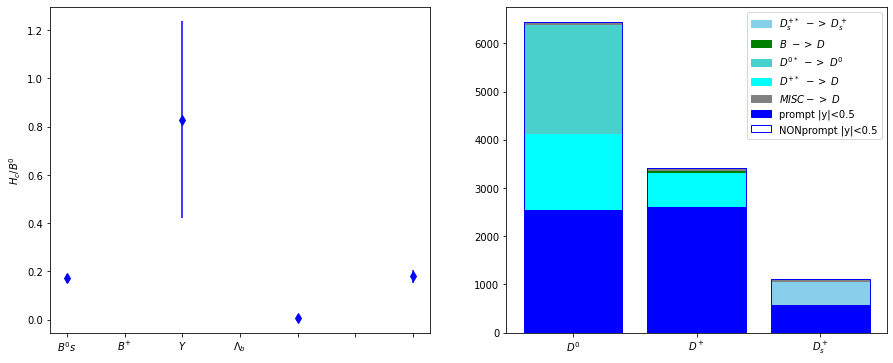

In [ ]:
SIM_health(TESTer, "B")

Searching for NONprompt ['D+', 'D+*', 'Ds', 'Ds*', 'Lambdac+', 'D0', 'D0*', 'Xic0', 'J/Psi', 'Upsilon', 'B0', 'B0s', 'B+', 'Lambdab0', 'K0S', 'Xi-', 'Omega-', 'Lambda', 'pi+', 'K+', 'K0'] in pp

 *------------------------------------------------------------------------------------* 
 |                                                                                    | 
 |  *------------------------------------------------------------------------------*  | 
 |  |                                                                              |  | 
 |  |                                                                              |  | 
 |  |   PPP   Y   Y  TTTTT  H   H  III    A      Welcome to the Lund Monte Carlo!  |  | 
 |  |   P  P   Y Y     T    H   H   I    A A     This is PYTHIA version 8.311      |  | 
 |  |   PPP     Y      T    HHHHH   I   AAAAA    Last date of change:  8 Mar 2024  |  | 
 |  |   P       Y      T    H   H   I   A   A                                      |  | 
 |  

<ipython-input-9-80faecdfec20>:100: UserWarning: FixedFormatter should only be used together with FixedLocator
  axs[0].set_xticklabels(noX)


B(D+* -> D+)= 31.469% while in PDG is 32.3% pm 0.5%
B(D+* -> D0)= 68.531% while in PDG is 67.7% pm 0.5%
B(D0* -> D0)= 100.0% while in PDG is ~100%
B(Ds* -> Ds)= 100.0% while in PDG is ~100%
PROMPT D+/D0= 1.021 while it should be ~1!


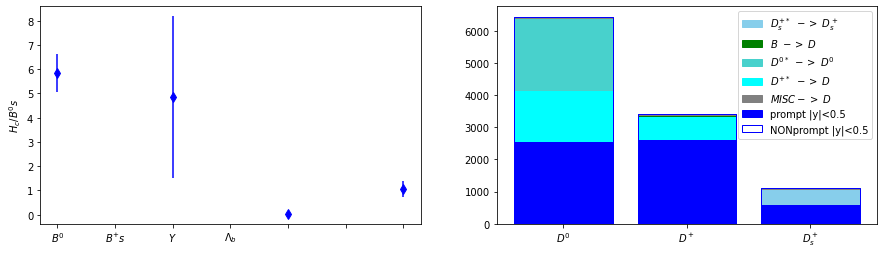

In [ ]:
SEARCH_these = ["D+", "D+*", "Ds", "Ds*", "Lambdac+", "D0", "D0*", "Xic0", "J/Psi",
                "Upsilon", "B0", "B0s", "B+", "Lambdab0",
                "K0S", "Xi-", "Omega-", "Lambda", "pi+", "K+", "K0" ]


#CHARMED_np = SIMULATE_collisions(["D+", "D+*", "Ds", "Ds*", "Lambdac+", "D0", "D0*", "Xic0", "J/Psi"], 100000, CR=True,  sim_h='D', stat_E=True, Selection="aby<0.5", production="NONprompt", quiet="yes")
#STRANGE_np = SIMULATE_collisions(["K0S","K+", "Xi-", "Omega-", "Lambda", "pi+"], 10000000, stat_E=True, sim_h='D', Selection="aby<0.5", TrackSEL="abeta<0.5")
#BEAUTY_np = SIMULATE_collisions(["Upsilon", "B0", "B0s", "B+", "Lambdab0"], 5000000, stat_E=True, production="NONprompt",  quiet="yes")





#PYTHIA8 = SIMULATE_collisions(SEARCH_these, 10000000, stat_E=True, sim_h='D',Selection="aby<0.5", TrackSEL="abeta<0.5", CR=True)




TESTer = SIMULATE_collisions(SEARCH_these, 200000, stat_E=True, sim_h='B', CR=True, quiet="yes")



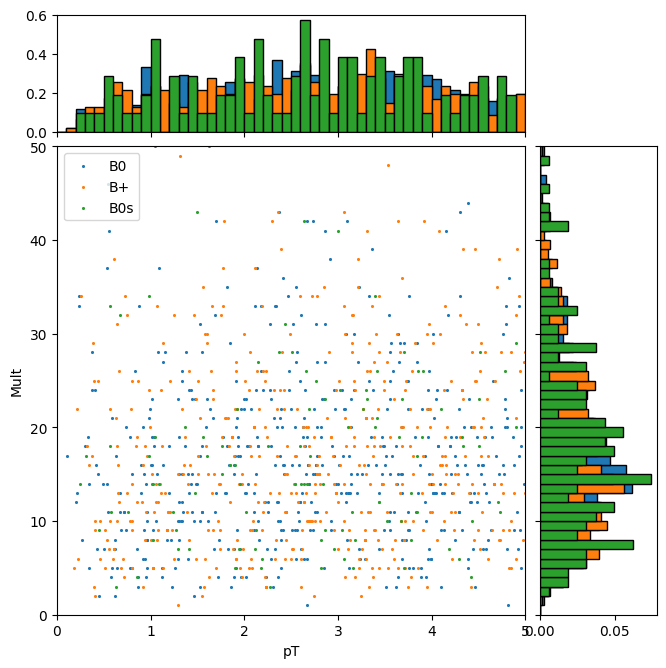

In [ ]:

#scatter_hist([BEAUTY_np], "B0s Lambdab0 Upsilon", "Mult pT", rangeX=[0,15],rangeY=[0,350]) 
#scatter_hist([STRANGE_np] , "Lambda Xi- Omega-", "Mult pT", rangeX=[0,5],rangeY=[0,50])
#scatter_hist([CHARMED_np], "D0 D+ Ds" , "Mult pT", rangeX=[0,5],rangeY=[0,350]) 

scatter_hist([PYTHIA8], "B0 B+ B0s" , "Mult pT", rangeX=[0,5],rangeY=[0,50]) 


In [ ]:
    SIM_health(HERWIG, "D")


NameError: name 'HERWIG' is not defined

Total counts of K0S is: 880760
Total counts of Lambda is: 416861
Total counts of pi+ is: 13871764


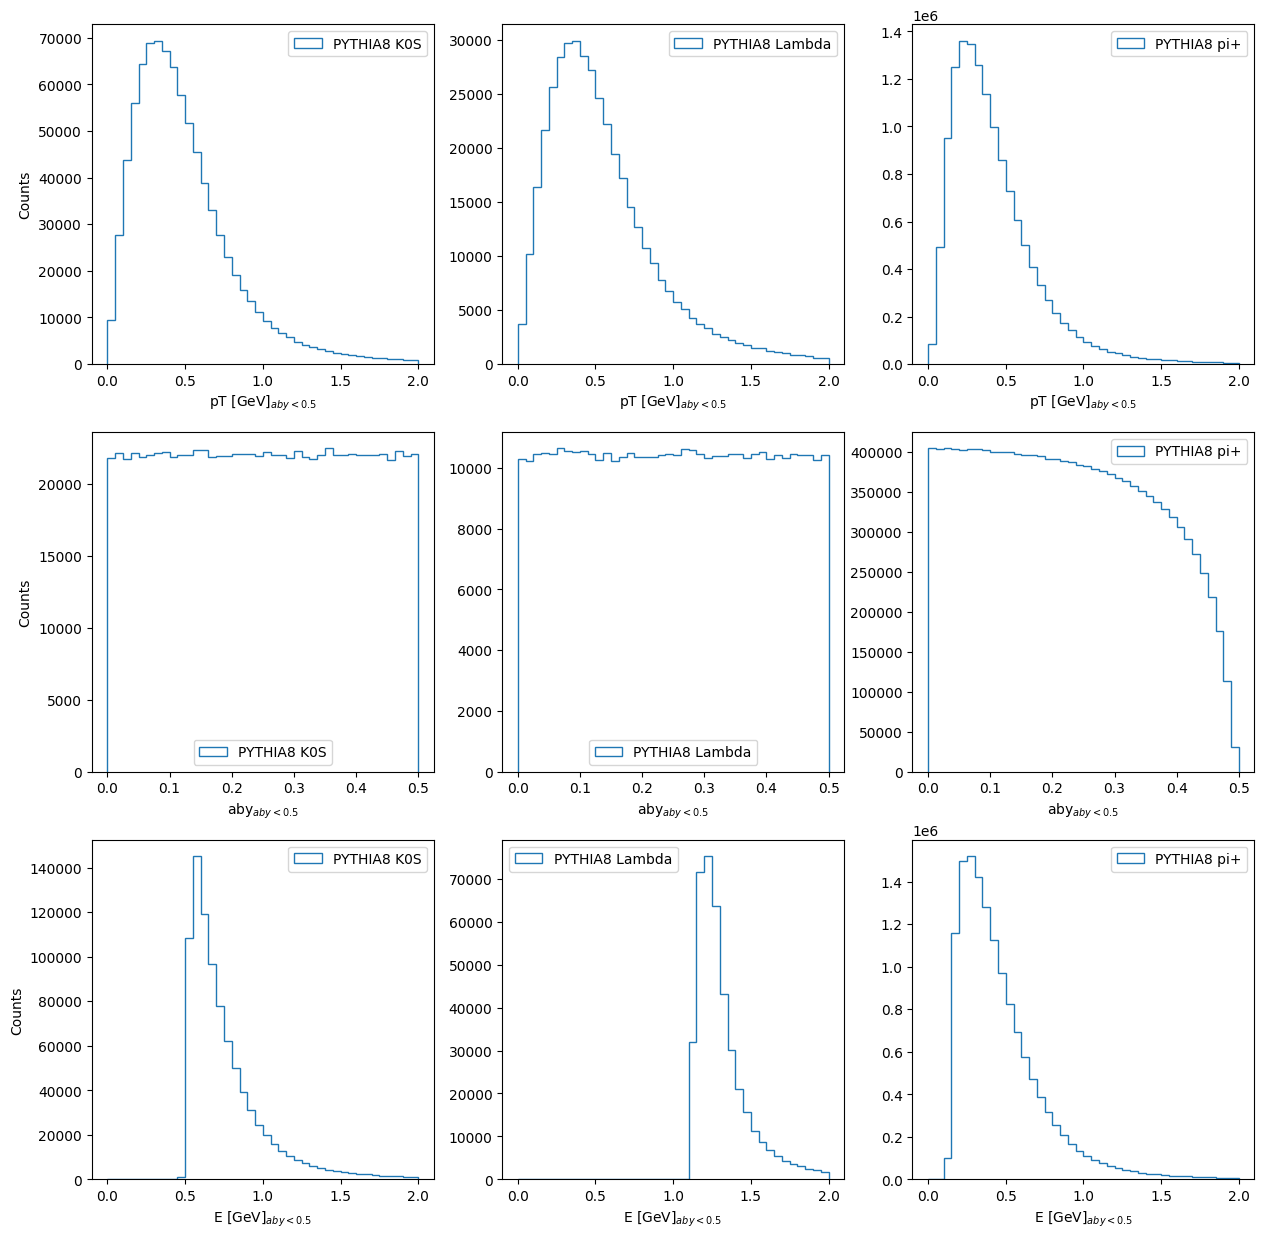

In [ ]:

#CHARM_axs = PLOTdistributions([CHARMED_np], ["D0", "D+", "Ds","Lambdac+"], ['pT','Mult'],RANGES=[[0,10],[0,300],[0,0.5]], NBins=20)
#BEAUTY_axs = PLOTdistributions([BEAUTY_np], ['B+', "B0","B0s", "Lambdab0"], ['pT','Mult'], RANGES=[[0,15],[0,300],[0,5]], NBins=20)
#STRANGE_axs = PLOTdistributions([STRANGE_np], ["K0S", "Lambda", "pi+"], ['pT','Mult'], RANGES=[[0,5],[0,50],[0,0.5]], NBins=40)

PYTHIA8_axs = PLOTdistributions([PYTHIA8], ["K0S", "Lambda", "pi+"], ['pT','aby','E'], RANGES=[[0,2],[0,0.5],[0,2]], NBins=40, norm=False)




In [ ]:
def PlotRatios( FragRlist , n_bins, ParD, Var2plotLIST, RANGEx=[[0,10],[0,350]], xlog=False, ylog=False):
    
    fig, axs = plt.subplots(len(Var2plotLIST)+1, figsize=(10, 20))
    axs[len(Var2plotLIST)].set_visible(False)
    
     
    for var in range(len(Var2plotLIST)):
    
        for ss in FragRlist:
            NUM, DEN = ss.split('/')
            if DEN[0]=="(":
                DEN = DEN[1:-1].split(" ")
            
            #loop through the DATAset
            
            bin_heights_DEN_list = []
            bin_heights_DEN_list_error = []
            for D in ParD:
                par_dic_variN=D["NOMINAL"]["PARTICLES_DIS"]
                par_dic_variU=D["forUNC"]["PARTICLES_DIS"]
                
                for key in par_dic_variN:
                            
                    if (NUM == key):
                        bin_heights_NUM, bin_edges = np.histogram(par_dic_variN[key][Var2plotLIST[var]] ,range=(RANGEx[var][0],RANGEx[var][1]), bins=n_bins)
                        bin_heights_NUM_error, _   = np.histogram(par_dic_variU[key][Var2plotLIST[var]] ,range=(RANGEx[var][0],RANGEx[var][1]), bins=n_bins)
                        bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2
                        bin_heights_NUM_error = abs(bin_heights_NUM_error-bin_heights_NUM)
                       
                    if (key in DEN):
                        bin_heights_DEN, _       = np.histogram(par_dic_variN[key][Var2plotLIST[var]],range=(RANGEx[var][0],RANGEx[var][1]), bins=n_bins)
                        bin_heights_DEN_error, _ = np.histogram(par_dic_variU[key][Var2plotLIST[var]],range=(RANGEx[var][0],RANGEx[var][1]), bins=n_bins)
                        bin_heights_DEN_list.append(bin_heights_DEN)
                        bin_heights_DEN_list_error.append(abs(bin_heights_DEN-bin_heights_DEN_error))

            bin_heights_DEN = np.zeros(len(bin_centers))
            for arr in bin_heights_DEN_list:
                bin_heights_DEN+= arr
                
            bin_error_DEN   = np.zeros(len(bin_centers))            
            for arr in bin_heights_DEN_list_error:
                bin_error_DEN+=arr**2
            bin_error_DEN=np.sqrt(bin_error_DEN)
            
            ratio=np.array(bin_heights_NUM/bin_heights_DEN)
            ratioU=ratio*np.sqrt( (bin_error_DEN/bin_heights_DEN)**2 + (bin_heights_NUM_error/bin_heights_NUM)**2 )
                        
            M='o'
            if NUM=="D+" or NUM=="D0" or NUM=="Ds" or NUM=="B+*":
                M="d"
            elif NUM=="B+" or NUM=="B0" or NUM=="B0s" or NUM=="Lambdab0":
                M='*'
                
            if ("D+" in NUM) and ("D0" == DEN) and Var2plotLIST[var] == "pT":
                plot_exp_DATA(axs[var], "https://www.hepdata.net/record/ins1511870?version=1&table=Table%205&format=root", "Table 5" , LEG='ALICE D+/D0', COR="red" )

            axs[var].errorbar(bin_centers, ratio, yerr=ratioU, fmt=M, label=D["SIMULATOR"]+' '+str(NUM)+'/'+str(DEN))
            axs[var].legend()
        
        axs[var].set_xlabel(Var2plotLIST[var])
        axs[var].set_xlim(RANGEx[var][0],RANGEx[var][1])

        if Var2plotLIST[var] == "pT":
            axs[var].set_xlabel(Var2plotLIST[var]+" (GeV/c)")
        axs[var].set_ylabel('Ratio')
        if ylog:
            axs[var].set_yscale('log')
        if xlog:
            axs[var].set_xscale('log')

        axs[var].axhline(y=1, color='black', linestyle='--', linewidth=1)            

    return 



#PlotRatios(["D+/D0","Ds/D0"] , 10, [CHARMED_np], ["pT"], [[0,5], [0,300]])
#PlotRatios(["B+/B0","B0s/B0"], 10, [BEAUTY_np] , ["pT","Mult"], [[0,10], [25,300]])
#PlotRatios(["K0S/pi+",] , 10, [STRANGE_np], ["pT"], [[0,5], [10,400]])


PlotRatios(["B+/B0","B0s/B0","D+/D0","Ds/D0"], 7, [PYTHIA8] , ["pT"], [[0,8], [0,30]])
#PlotRatios(["D+/D0","Ds/D0"] , 10, [PYTHIA8] , ["pT","Mult"], [[0,5] , [0,30]])
#PlotRatios(["K0S/pi+",] , 10, [PYTHIA8], ["pT"], [[0,5], [5,400]])

NameError: name 'PYTHIA8' is not defined

In [ ]:
def plotEVTmultH(parD, Par2PlotL, RANGEx=[0,50], BINs=20, racio2pi=False):
    
    fig, axs = plt.subplots(len(Par2PlotL)+1, figsize=(8, 40))
    if not racio2pi:
        axs[len(Par2PlotL)].set_visible(False)
    
    part_data={}
    
    for p in range(len(Par2PlotL)):
        NUM_list=[]
        NUM_listE=[]
        Multi=[]
        MultiE=[]

        for i in parD["NOMINAL"]["Evt"]:
                if Par2PlotL[p] in parD["NOMINAL"]["Evt"][i]["PARTICLES"]:
                    NUM_list.append(len(parD["NOMINAL"]["Evt"][i]["PARTICLES"][Par2PlotL[p]]["pT"]))
                else:
                    NUM_list.append(0)
                Multi.append(parD["NOMINAL"]["Evt"][i]["Mult"])
            
        for i in parD["forUNC"]["Evt"]:
                if Par2PlotL[p] in parD["forUNC"]["Evt"][i]["PARTICLES"]:
                    NUM_listE.append(len(parD["forUNC"]["Evt"][i]["PARTICLES"][Par2PlotL[p]]["pT"]))
                else:
                    NUM_listE.append(0)
                MultiE.append(parD["forUNC"]["Evt"][i]["Mult"])

        NUM_list=np.array(NUM_list)
        NUM_listE=np.array(NUM_listE)
            
        if Par2PlotL[p] == "pi+":
            plot_exp_DATA(axs[p], "https://www.hepdata.net/record/ins1471838?version=1&table=Table%2040&format=root", "Table 40" , LEG='ALICE pi+', COR="red", symSYS=True)

        elif Par2PlotL[p] == "K0S":
            plot_exp_DATA(axs[p], "https://www.hepdata.net/record/ins1471838?version=1&table=Table%2042&format=root", "Table 42" , LEG='ALICE K0S', COR="red", symSYS=True )

        elif Par2PlotL[p] == "Lambda":
            plot_exp_DATA(axs[p], "https://www.hepdata.net/record/ins1471838?version=1&table=Table%2043&format=root", "Table 43" , LEG='ALICE Lambda', COR="red", symSYS=True )
        
        elif Par2PlotL[p] == "Xi-":
            plot_exp_DATA(axs[p], "https://www.hepdata.net/record/ins1471838?version=1&table=Table%2044&format=root", "Table 44" , LEG='ALICE Xi-', COR="red", symSYS=True )

        elif Par2PlotL[p] == "Omega-":
            plot_exp_DATA(axs[p], "https://www.hepdata.net/record/ins1471838?version=1&table=Table%2045&format=root", "Table 45" , LEG='ALICE Omega-', COR="red", symSYS=True )

        counts, bin_edges = np.histogram(Multi, bins=BINs, range=(RANGEx[0],RANGEx[1]))
        countsE, _  = np.histogram(MultiE, bins=BINs, range=(RANGEx[0],RANGEx[1]))
        bin_centers = 0.5 * (bin_edges[:-1] + bin_edges[1:])

        # Calculate bin averages
        bin_averages = np.zeros_like(bin_centers)
        bin_averagesE = np.zeros_like(bin_centers)

        for i in range(len(bin_edges) - 1):
            bin_mask = (Multi >= bin_edges[i]) & (Multi < bin_edges[i + 1])
            bin_maskE = (MultiE >= bin_edges[i]) & (MultiE < bin_edges[i + 1])
            bin_averages[i] = np.mean(NUM_list[bin_mask])
            bin_averagesE[i] = np.mean(NUM_listE[bin_maskE])
            
        bin_error=abs(bin_averages-bin_averagesE)
        
        # Plot bin averages
        axs[p].errorbar(bin_centers, bin_averages,bin_error, color="blue",fmt='o', label=parD["SIMULATOR"]+' '+str(Par2PlotL[p]))
        part_data[Par2PlotL[p]]=[bin_centers, bin_averages, bin_error]

        axs[p].set_xlabel("Evt Mult"+"$_{"+str(parD["Selection"])+"}$")
        axs[p].set_ylabel('<counts>')
        axs[p].legend()
        axs[p].set_xlim(RANGEx[0],RANGEx[1])
        
    
    if racio2pi:
        plot_exp_DATA(axs[p+1], "https://www.hepdata.net/record/ins1471838?version=1&table=Table%2036&format=root", "Table 36" , LEG='ALICE 2K0S/pi+ ', COR="black", symSYS=True )
        plot_exp_DATA(axs[p+1], "https://www.hepdata.net/record/ins1471838?version=1&table=Table%2037&format=root", "Table 37" , LEG='ALICE Lambda/pi+ ', COR="blue", symSYS=True, f=1 )
        plot_exp_DATA(axs[p+1], "https://www.hepdata.net/record/ins1471838?version=1&table=Table%2038&format=root", "Table 38" , LEG='ALICE Xi-/pi+ ', COR="green", symSYS=True,f=1 )
        plot_exp_DATA(axs[p+1], "https://www.hepdata.net/record/ins1471838?version=1&table=Table%2039&format=root", "Table 39" , LEG='ALICE Omega-/pi+ ', COR="red", symSYS=True,f=1 )

        for par in Par2PlotL:    
            if  par == "K0":
                factor=1
                color="black"
            elif par== "Lambda":
                factor=1
                color="blue"
            elif par== "Xi-":
                factor=1
                color="green"
            elif par== "Omega-":
                factor=1
                color="red"
                
            if par != "pi+" and par != "K0S" and par != "K+":
                y_div=factor*part_data[par][1]/part_data["pi+"][1]
                error_y_div = y_div * np.sqrt((part_data[par][2] / part_data[par][1])**2 + (part_data["pi+"][2] / part_data["pi+"][1])**2)
                axs[p+1].errorbar(part_data[par][0],factor*y_div, error_y_div, fmt=".",color=color )
            
        axs[p+1].set_yscale('log')
        axs[p+1].set_xscale('log')
        axs[p+1].set_ylabel('Ratio to (p+pi-)')
        axs[p+1].set_xlabel('Evt Mult')
        
        axs[p+1].set_xlim(2,25)

    plt.show()    


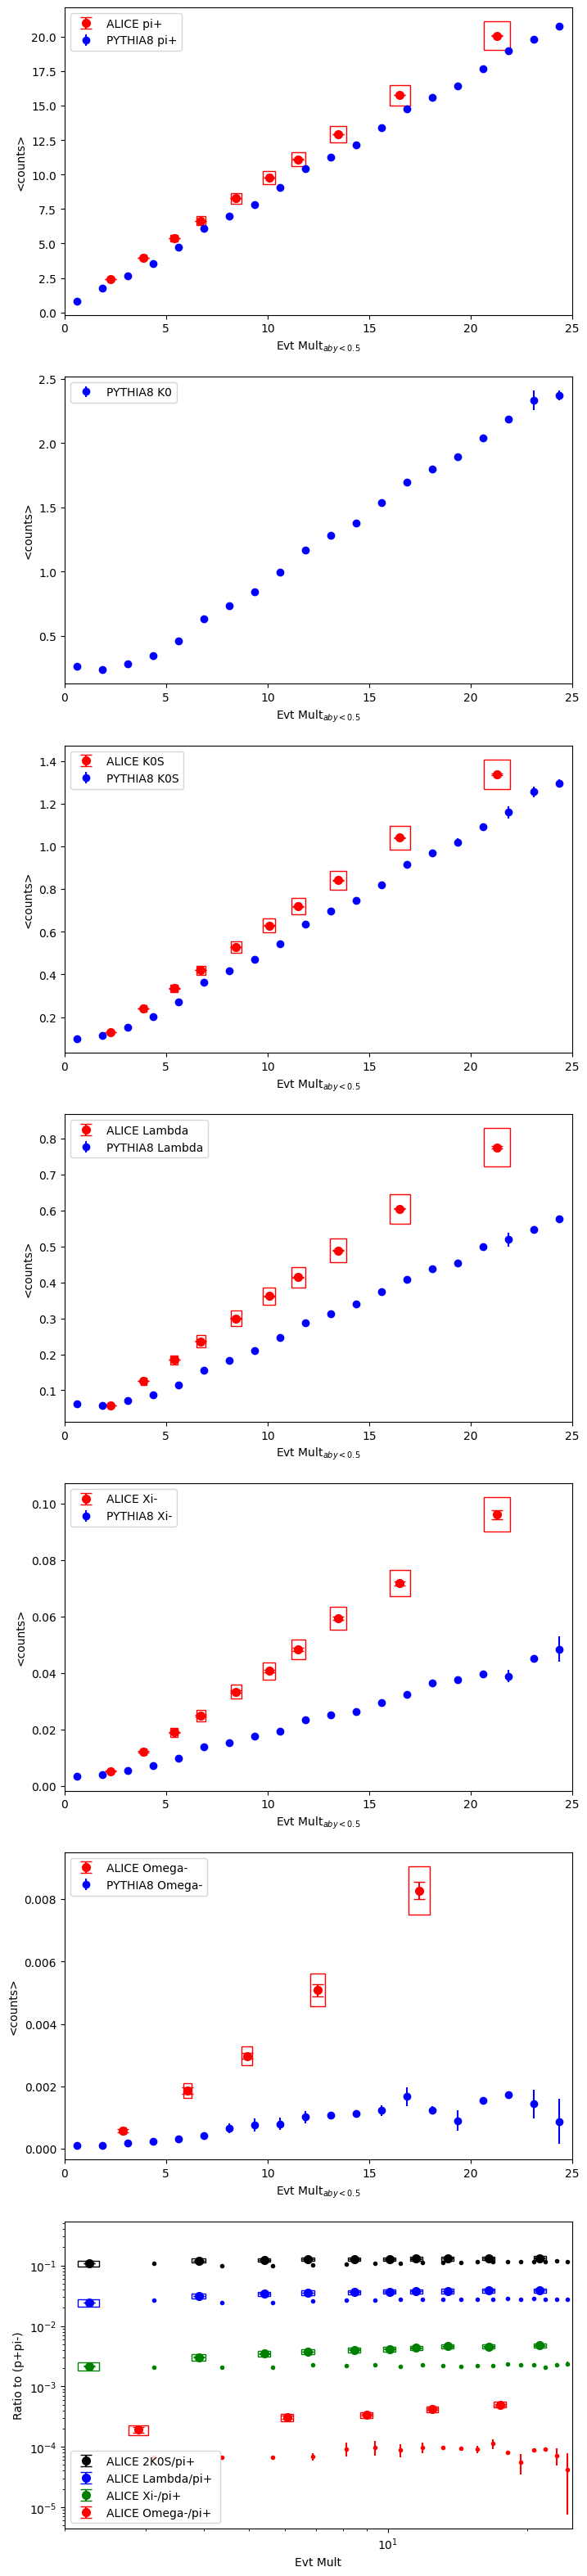

In [ ]:
plotEVTmultH(PYTHIA8, ["pi+", "K0", "K0S", "Lambda", "Xi-", "Omega-"], RANGEx=[0,25], BINs=20, racio2pi=1)

In [ ]:
def apply_cut(dictionaryDATA, condition):
    dicCUT = copy.deepcopy(dictionaryDATA) 
    for par, data in dicCUT["PARTICLES_DIS"].items():
        if (type(data)==str or type(data)==int):
            continue
        mask = eval(condition, {}, data)
        for key in data:
            data[key] = [val for val, m in zip(data[key], mask) if m]
    if dictionaryDATA["Selection"] == "No Cuts":
        dicCUT["Selection"]=condition.split("for")[0][1:]
    else:
        dicCUT["Selection"]=copy.deepcopy(dictionaryDATA["Selection"])+" "+condition.split("for")[0][1:]

    return dicCUT


# ##Example usage: (in the case of multiple variables USE ZIP!
# condition = "[(pt > 10 and Mult < 30) or (pt < 10 and aby > 4) for pt, Mult, aby in zip(pt, Mult, aby)]"





PYTHIA_np_CUT  = apply_cut(PYTHIA8["NOMINAL"], "[(aby > 3.0) for aby in aby]")
print("done")
PYTHIA_np_CUT2 = apply_cut(PYTHIA8["NOMINAL"], "[(Mult > 200) for Mult in Mult]")
print("done")

H_np_CUT  = apply_cut(HERWIG["NOMINAL"], "[(aby > 3.0) for aby in aby]")
print("done")

H_np_CUT2 = apply_cut(HERWIG["NOMINAL"], "[(Mult > 200) for Mult in Mult]")


#PYTHIA_np_CUT3 = apply_cut(PYTHIA8["NOMINAL"], "[(Mult < 150) for Mult in Mult]")

NameError: name 'PYTHIA8' is not defined

In [ ]:
BEAUTY_CUT_axs = PLOTdistributions([PYTHIA8,PYTHIA_np_CUT,PYTHIA_np_CUT2], 
                                   ["B0", "B+", "B0s"], ["E",'pT'], 
                                   RANGES=[[5,200],[0,20],[0,10]], NBins=25, ht="bar")



In [ ]:
# def GET_HEP_DATA(url, name, NOx= False):
    
#     folder = uproot.open(BytesIO(requests.get(url).content))[name]
#     histograms = folder.keys()
#     exp_data=[] 
#     binWidth=[]
#     exp_data.append( np.array(folder[histograms[0]].axis().edges()))
        
#     if not NOx:
#         exp_data[0]= (exp_data[0][:-1] + exp_data[0][1:]) / 2
#         for i in range(len(exp_data[0])):
#             binWidth.append(abs(np.array(folder[histograms[0]].axis().edges())[i] - exp_data[0][i]))
    
#     for hist_n in range(len(histograms[:-1])):
#         exp_data.append(folder[histograms[hist_n]].values())
        
#     mask=exp_data[1]!=0
    
#     if not NOx:
#         for i in range(len(exp_data)):
#             exp_data[i]=exp_data[i][mask]
#         binWidth=np.array(binWidth)[mask]

#     return exp_data, binWidth


# def plot_exp_DATA(grafico, u_r_l, CONTENTname , LEG, noX=[], COR="red", symSYS=False, f=1):
#     if noX==[]:
#         D_hep_data, binW = GET_HEP_DATA(u_r_l, CONTENTname)
#         bin_c=D_hep_data[0]
#         bin_r=range(len(bin_c))
#     else:
#         D_hep_data, _ = GET_HEP_DATA(u_r_l, CONTENTname, NOx=True)
#         bin_c=range(len(noX))
#         bin_r=bin_c
#         binW=[]
#         print(D_hep_data[0],D_hep_data[1],bin_c)
#         for j in bin_c:
#             binW.append(0.1)
#         grafico.set_xticks(bin_c)
#         grafico.set_xticklabels(noX)
        
#     grafico.errorbar(bin_c, f*D_hep_data[1], yerr=D_hep_data[2], fmt='o', label=LEG, markersize=7, capsize=5,color=COR)

#     # Plot box-style error bars manually                
#     for i in bin_r:
#         lower_bound = f*D_hep_data[1][i] + D_hep_data[4][i]
#         upper_bound = f*D_hep_data[1][i] + D_hep_data[3][i]
#         if symSYS:
#             lower_bound=f*D_hep_data[1][i] - D_hep_data[3][i]
#         height = upper_bound - lower_bound
#         grafico.add_patch(
#         plt.Rectangle((bin_c[i] - binW[i], lower_bound), binW[i]*2, height, edgecolor=COR, facecolor='none')
#         )
        
#     grafico.legend()
#     grafico.grid(False) 
    
#     return bin_c,D_hep_data[1]



def plot_pseudorapidity_lines(pseudorapidities, x_range=(0, 10), num_points=400):
    x = np.linspace(x_range[0], x_range[1], num_points)
    specific_etaplot = [0.5, 1000, 0.0001]
    plt.figure(figsize=(10, 10))
    plt.gca().spines['top'].set_visible(False)
    plt.gca().spines['right'].set_visible(False)
    plt.gca().spines['bottom'].set_visible(False)
    plt.gca().spines['left'].set_visible(False)   
    
    def plot_eta_line(eta, color, linestyle, label=None, annotate=False, lnw=1):
        theta = 2 * math.atan(math.exp(-eta))
        slope = math.tan(theta)
        y = slope * x
        line, = plt.plot(x, y, color=color, linewidth = lnw, linestyle=linestyle, label=label)
        
        if annotate:
            midpoint = num_points // 2
           
            xXX=x[midpoint]
            yYY=y[midpoint]
            if eta<0.1:
                xXX=0.5
                yYY=9       
                eta="0"
            elif eta>10:
                eta="+inf"

            plt.annotate(f'η = {eta}', (xXX, yYY), textcoords="offset points", xytext=(0,10), ha='center', color=color)
    

    # Plot other pseudorapidity lines in light blue dashed
    cc=["darkorange","lightblue"]
    counter=0
    for li in pseudorapidities:
        for eta in li["NOMINAL"]["Evt"][0]["PARTICLES"]["pi+"]["abeta"]:
            plot_eta_line(eta, color=cc[counter],lnw=0.5, linestyle='--', label=li["SIMULATOR"])
        counter+=1

    # Plot specific lines in red solid
    for eta in specific_etaplot:
        plot_eta_line(eta, color='red', linestyle='-', lnw=2,label=None, annotate=True)
    
    # Remove grid
    plt.grid(False)
    
    # Remove xy-axis ticks and label
    plt.gca().yaxis.set_ticks([])
    plt.gca().yaxis.set_ticklabels([])
    plt.gca().set_ylabel('')
    plt.gca().xaxis.set_ticks([])
    plt.gca().xaxis.set_ticklabels([])
    plt.gca().set_xlabel('')
    
    # Set the legend only once for "Herwig"
    handles, labels = plt.gca().get_legend_handles_labels()
    by_label = dict(zip(labels, handles))
    plt.legend(by_label.values(), by_label.keys())
    
    plt.xlim((0,10))
    plt.ylim((0,10))
    # Show the plot

    plt.show()
    

    
    
############################################################################################
############################################################################################
    
    
def scatter_hist(parDIC, pairs , VARvs, rangeX=[0,15], rangeY=[0,300] ):
    
    particles=pairs.split(" ")
    var = VARvs.split(" ")
    
    fig = plt.figure(figsize=(6, 6))
    gs = fig.add_gridspec(2, 2,  width_ratios=(4, 1), height_ratios=(1, 4),
                        left=0.1, right=1.1, bottom=0.1, top=1.1, wspace=0.05, hspace=0.05)
    
    ax = fig.add_subplot(gs[1, 0])
    ax_histx = fig.add_subplot(gs[0, 0], sharex=ax)
    ax_histy = fig.add_subplot(gs[1, 1], sharey=ax)
    
    # no labels
    ax_histx.tick_params(axis="x", labelbottom=False)
    ax_histy.tick_params(axis="y", labelleft=False)
    
    for par_dic in parDIC:
        par_dic_vari=par_dic["NOMINAL"]["PARTICLES_DIS"]
        
        for par in particles:
            if par in par_dic_vari and (len(par_dic_vari[par][var[1]]) !=0):
                ax.scatter(par_dic_vari[par][var[1]], par_dic_vari[par][var[0]],s=20, marker='.',linewidths=0, label=par)
                ax_histy.hist(par_dic_vari[par][var[0]] , density=True, range=(rangeY[0],rangeY[1]), bins=50, orientation='horizontal', edgecolor='black')
                ax_histx.hist(par_dic_vari[par][var[1]] , density=True, range=(rangeX[0],rangeX[1]), bins=50, edgecolor='black')

    ax.legend()
    ax.set_xlabel(var[1])
    ax.set_xlim(rangeX[0],rangeX[1])
    ax.set_ylim(rangeY[0],rangeY[1])
    ax.set_ylabel(var[0])
    plt.show()
    
    
    
    
############################################################################################
############################################################################################
############################################################################################
############################################################################################


def counter_PAR(p_name, p_mother, pip, pdic):        

    ############# INITIALIZE THE DIC (if thats the case)
    if pdic["COUNTS"]=={}:
        #SPECIAL CASES to be counted
        pdic["COUNTS"] = {"D+_FROM_D+*":0,
                    "D0_FROM_D+*" :0,
                    "D0_FROM_D0*" :0,
                    "Ds_FROM_Ds*" :0,
                    "D+_FROM_B(s)":0,
                    "D0_FROM_B(s)":0,
                    "Ds_FROM_B(s)":0,
                    "D0_FROM_ANY":0,
                    "Ds_FROM_ANY":0,
                    "D+_FROM_ANY":0}
        #SPECIAL CASES to be counted

        for keys in Particle_names:
            if keys == "2212":
                pdic["COUNTS"]["NONpromptp"]=-2 #there are always 2 protons in each event
                pdic["COUNTS"]["promptp"]   = 0 
            elif keys not in ["21","22","1","2","3","4","5","6","90","81"]: #lets not count NON-observable particles
                pdic["COUNTS"]["NONprompt"+Particle_names[keys]]=0
                pdic["COUNTS"]["prompt"+Particle_names[keys]]=0
    ############# INITIALIZE THE DIC (if thats the case)

    
    if p_name not in ["uQ", "dQ", "cQ", "sQ", "tQ", "bQ", "gluon", 'photon', "COL system", "CLUSTER"]:
                
        pdic["COUNTS"]["NONprompt"+p_name]+=1
        if pip:
            pdic["COUNTS"]["prompt"+p_name]+=1
            
        if not pip:
            
            if (p_name == "Ds"):
                if (p_mother == "Ds*"):
                    pdic["COUNTS"]["Ds_FROM_Ds*"] +=1
                else:
                    pdic["COUNTS"]["Ds_FROM_ANY"]+=1

            elif (p_name == "D0"):
                if (p_mother == "D+*"): 
                    pdic["COUNTS"]["D0_FROM_D+*"] +=1
                elif (p_mother in ["B+","B0s","B0","B0*","B+*","B0s*"]): 
                    pdic["COUNTS"]["D0_FROM_B(s)"]+=1  
                elif (p_mother == "D0*"): 
                    pdic["COUNTS"]["D0_FROM_D0*"] +=1  
                else:
                    pdic["COUNTS"]["D0_FROM_ANY"]+=1

            elif (p_name == "D+"):
                if (p_mother == "D+*") : 
                    pdic["COUNTS"]["D+_FROM_D+*"] +=1
                elif (p_mother in ["B+","B0s","B0","B0*","B+*","B0s*"]):
                    pdic["COUNTS"]["D+_FROM_B(s)"]+=1
                else:
                    pdic["COUNTS"]["D+_FROM_ANY"]+=1
        #SPECIAL CASES

        
def checkparID(lparID):
    
    IDs=[]
    for i in lparID:
        if str(i) not in Particle_names:
            IDs.append(99099)
        else:
            IDs.append(i)

    return IDs



############################################################################################
############################################################################################
############################################################################################
############################################################################################



############################################################################################
############################################################################################



def PLOTdistributions(ParDIC, Par2plotLIST, Var2plotLIST, RANGES=[], NBins=20,norm=False, ht='step'):
    
    VarN=len(Var2plotLIST)
    ParN=len(Par2plotLIST)
        
    fig, axs = plt.subplots(VarN, ParN, figsize=(15, 15))
    
    for Pdic in ParDIC:
        par_dic_vari=Pdic["NOMINAL"]["PARTICLES_DIS"]

        for i in range(ParN):
            for j in range(VarN):
                
                if Par2plotLIST[i] in par_dic_vari:

                    legend_extra = "$_{"+str(Pdic["Selection"])+"}$"
                    if Var2plotLIST[j]== "E":
                        legend_extra = " [GeV]$_{"+str(Pdic["Selection"])+"}$"
                    elif Var2plotLIST[j] == "pT":
                        legend_extra = " [GeV]$_{"+str(Pdic["Selection"])+"}$"

                    axs[j, i].hist(par_dic_vari[Par2plotLIST[i]][Var2plotLIST[j]], density=norm, histtype=ht, bins=NBins, range=(RANGES[j][0], RANGES[j][1]), alpha=1, label=Pdic["SIMULATOR"]+ ' '+ Par2plotLIST[i])
                    axs[j, i].set_xlabel(Var2plotLIST[j]+legend_extra)
                    if i==0:
                        axs[j, i].set_ylabel('Counts')
                    #axs[j, i].set_title(Par2plotLIST[i])
                    axs[j, i].legend()
            
        for i in range(ParN):
            if Par2plotLIST[i] in par_dic_vari:
                print("Total counts of " + Par2plotLIST[i] + " is: " + str(len(par_dic_vari[Par2plotLIST[i]]["pT"])) )

    return axs

############################################################################################
############################################################################################

In [ ]:
#######################
####################### 
#        CHARM        #
#######################
#######################
#######################
####################### 
# COMPARISON W/ ALICE #
#######################
#######################



def SIM_health(parDL, parti):
    
    if parti!='':
        print("SIMULATION HEALTH")

    if "D" in parti:
        
        fig, axs = plt.subplots(1, 2, figsize=(15, 6))
        x = [r"$D^+$", r"$D^{+*}$", r"$D_s^+$", r"$\Lambda_c^+$", r"$\Xi_c^0$", r"$J/\Psi$"]
        x_num = range(len(x))
        MCnp=[]
        MCnpe=[]
        MCp=[]
        dicP_counter = parDL["NOMINAL"]["COUNTS"]
        dicP_counterE = parDL["forUNC"]["COUNTS"]

        for p in ["NONpromptD+", "NONpromptD+*", "NONpromptDs", "NONpromptLambdac+", "NONpromptXic0", "NONpromptJ/Psi" ]:
                MCnp.append( dicP_counter[p]/dicP_counter["NONpromptD0"])
                MCnpe.append(dicP_counterE[p]/dicP_counterE["NONpromptD0"])
        for p in ["promptD+", "promptD+*", "promptDs", "promptLambdac+", "promptXic0", "promptJ/Psi" ]:
                MCp.append(  dicP_counter[p]/dicP_counter["promptD0"] )

        MCnpEE = abs(np.array(MCnp)-np.array(MCnpe))

        axs[0].errorbar(x_num, MCnp, yerr=MCnpEE,  fmt='d', label=parDL["SIMULATOR"]+""+'NONprompt |y|<0.5', markersize=7, color="blue")
        #plot_exp_DATA(axs[0], "https://www.hepdata.net/record/ins1863128?version=1&table=Table%201&format=root", "Table 1" , LEG='ALICE D+ |y|<0.5', COR="red", noX=[r"$D^+$", r"$D^{+*}$", r"$D_s^+$", r"$\Lambda_c^+$", r"$\Xi_c^0$", r"$J/\Psi$"] )

        axs[0].set_xticklabels(x)
        axs[0].set_ylabel('$H_c/D^0$')

        categories=["$D^0$","$D^+$","$D^+_s$"]
        nonprt     = np.array([dicP_counter["NONpromptD0"] ,dicP_counter["NONpromptD+"] ,dicP_counter["NONpromptDs"]])
        prt        = np.array([dicP_counter["promptD0"]    ,dicP_counter["promptD+"]    ,dicP_counter["promptDs"]])
        prt_Bmesons= np.array([dicP_counter["D0_FROM_B(s)"],dicP_counter["D+_FROM_B(s)"],dicP_counter["Ds_FROM_B(s)"]])
        prt_Dpstar = np.array([dicP_counter["D0_FROM_D+*"] ,dicP_counter["D+_FROM_D+*"] ,0])
        prt_D0star = np.array([dicP_counter["D0_FROM_D0*"] ,0 ,0])
        prt_Dsstar = np.array([0,0,dicP_counter["Ds_FROM_Ds*"]]) 
        prt_any = np.array([dicP_counter["D0_FROM_ANY"],dicP_counter["D+_FROM_ANY"],dicP_counter["Ds_FROM_ANY"]])
        # Plot
        axs[1].bar(categories, prt_Dsstar , facecolor='skyblue', edgecolor='skyblue', label='$D_s^{+*}~->~D_s^+$', bottom=prt)    
        axs[1].bar(categories, prt_Bmesons, facecolor='g'      , edgecolor='g'      , label='$B~->~D$'           , bottom=prt+prt_Dpstar+ prt_D0star)   
        axs[1].bar(categories, prt_D0star , facecolor='mediumturquoise', edgecolor='mediumturquoise', label='$D^{0*}~->~D^0$', bottom=prt+prt_Dpstar)  
        axs[1].bar(categories, prt_Dpstar , facecolor='cyan'   , edgecolor='cyan'   , label='$D^{+*}~->~D$'      , bottom=prt)   
        axs[1].bar(categories, prt_any    , facecolor='grey', edgecolor='grey', label='$MISC->~D$', bottom=prt+prt_Dpstar+ prt_D0star+prt_Dsstar+prt_Bmesons)  

        axs[1].bar(categories, prt        , facecolor='blue'   , edgecolor='blue'   , label='prompt |y|<0.5')    
        axs[1].bar(categories, nonprt     , facecolor='none'   , edgecolor='blue'   , label='NONprompt |y|<0.5') 

        # Customize x-ticks to show category labels
        axs[1].set_xticks(range(len(categories)))
        axs[1].set_xticklabels(categories)
        # Add legend
        axs[1].legend()
        axs[1].grid(False)
        
        print("B(D+* -> D+)= " + str(round(100*dicP_counter["D+_FROM_D+*"] / dicP_counter["NONpromptD+*"],3)) + "% while in PDG is 32.3% pm 0.5%")
        print("B(D+* -> D0)= " + str(round(100*dicP_counter["D0_FROM_D+*"] / dicP_counter["NONpromptD+*"],3)) + "% while in PDG is 67.7% pm 0.5%")
        print("B(D0* -> D0)= " + str(round(100*dicP_counter["D0_FROM_D0*"] / dicP_counter["NONpromptD0*"],3)) + "% while in PDG is ~100%")
        print("B(Ds* -> Ds)= " + str(round(100*dicP_counter["Ds_FROM_Ds*"] / dicP_counter["NONpromptDs*"],3)) + "% while in PDG is ~100%")
        print("PROMPT D+/D0= " + str(round(    dicP_counter["promptD+"]    / dicP_counter["promptD0"],3)) + " while it should be ~1!")

        # Show plot
        plt.show()
        
    else parti == "B":
        return 

#######################
####################### 
#        CHARM        #
#######################
#######################
#######################
####################### 
# COMPARISON W/ ALICE #
#######################
#######################

SyntaxError: invalid syntax (<ipython-input-24-782863afb6e8>, line 78)

In [ ]:
eve

<GenEvent momentum_unit=1, length_unit=0, event_number=1, particles=851, vertices=467, run_info=GenRunInfo(tools=[], weight_names=['Default'], attributes={})>

In [ ]:
def ANA_Her_collisions(SEARCH_FOR, FILE, production="NONprompt", quiet="yes", Selection="True", TrackSEL = "True", sim_h="D"):
    col_sys="pp"
    
    PARTICLES_Wstat_U={}     
    #SAVE SELECTION conditions for future reference!! 
    PARTICLES_Wstat_U = {"promptNONprompt" : production }
    PARTICLES_Wstat_U["SIMULATOR"] = "HERWIG" 
    if Selection == "True":
        PARTICLES_Wstat_U["Selection"] = "No Cuts"
    else:
        PARTICLES_Wstat_U["Selection"] = Selection
    if TrackSEL == "True":
        PARTICLES_Wstat_U["TrackSEL"] = "No Cuts"
    else:
        PARTICLES_Wstat_U["TrackSEL"] = TrackSEL
    #SAVE SELECTION conditions for future reference!!
    
    
    print("Searching for " + production + " " + str(SEARCH_FOR) + " in " + col_sys )
    key="NOMINAL"

    PARTICLES_Wstat_U[key]={"Evt":{},
                            "COUNTS":{},
                            "PARTICLES_DIS":{}}
    for p in SEARCH_FOR:
        PARTICLES_Wstat_U[key]["PARTICLES_DIS"][p]={"pT":[], "aby":[], "abeta":[], "E":[], "Mult":[], "pL":[]}
    
    
    
    ###################################
    reader = pyhepmc.open(FILE)
    i=0 #just a counter
        
    for event in reader:
        
        if i % 1000 == 0:
            print(f"Processed {i} events")
    
        EVENT_INFO={"PARTICLES":{},
                    "Mult": 0 }
        state_in_evt=[] #to produce distributions

        for particle in event.particles:
                
            #Particles and their linage
            par_id = abs(particle.pid)
            
            if particle.parents == []:
                par_mother = 2212
                par_mother2_id = 2212
            else: 
                par_mother = abs(particle.parents[0].pid)
                if particle.parents[0].parents == []:
                    par_mother2_id = 2212
                else:
                    par_mother2_id=abs(particle.parents[0].parents[0].pid)
            
            par_id, par_mother1_id, par_mother2_id = checkparID([par_id, par_mother, par_mother2_id])
            par_is_prompt = abs(par_mother1_id) == 81

            par_name = Particle_names[str(par_id)]
            par_mother1_name = Particle_names[str(par_mother1_id)]
            #Particles and their linage

            #Particles Kinematic
            abeta=abs(particle.momentum.eta())
            pL=abs(particle.momentum.pz)
            E=particle.momentum.e
            if E != pL:
                aby = abs(0.5 * (np.log((E + pL) / (E - pL))) )
            else:
                aby = float('inf')
            pT=particle.momentum.pt()
            #Particles Kinematics

            #find the EVENT multiplicity!
            if particle.status == 1 and abs(Particle.from_pdgid(particle.pid).charge)>0 and eval(TrackSEL):
                EVENT_INFO["Mult"]+=1
            #find the EVENT multiplicity!

            ##PARTICLES in EVENT 
            if (par_mother1_id != par_id) and ( (particle.status == 1 and eval(TrackSEL)) or (particle.status != 1 and eval(Selection)) ):
                if(par_name in SEARCH_FOR):

                    if par_name not in EVENT_INFO["PARTICLES"]:
                        EVENT_INFO["PARTICLES"][par_name]={"pT":[],"aby":[],"E":[],"abeta":[]}

                    if (production=="prompt"):
                        SpecCasesK0S = (Particle_names[str(par_id)] == "K0S") & (par_mother1_name == "K0") & ((0 < par_mother2_id<7) or (par_mother2_id==21))
                        if(par_is_prompt) or SpecCasesK0S:
                            state_in_evt.append(particle)
                            #EVENT_INFO["PARTICLES"][par_name]["E"].append(E)
                            EVENT_INFO["PARTICLES"][par_name]["pT"].append(pT)
                            #EVENT_INFO["PARTICLES"][par_name]["aby"].append(aby)

                    elif (production=="NONprompt") :
                            state_in_evt.append(particle)
                            #EVENT_INFO["PARTICLES"][par_name]["E"].append(E)
                            EVENT_INFO["PARTICLES"][par_name]["pT"].append(pT)
                            #EVENT_INFO["PARTICLES"][par_name]["aby"].append(aby)
                            EVENT_INFO["PARTICLES"][par_name]["abeta"].append(abeta)

                    #print what is going on
                    if (quiet=="no") and (n==0):
                        if par_is_prompt:
                            print("event " + str(i) + " has a prompt " + par_name)
                        else:
                            print("event " + str(i) + " has a NONprompt " + par_name + " coming from a " + Particle_names[str(par_mother1_id)])
                    #print what is going on

                #DETAILED COUNTING  
                counter_PAR(par_name, par_mother1_name, par_is_prompt, PARTICLES_Wstat_U[key])
                #DETAILED COUNTING

        for state in state_in_evt:
            state_id=str(abs(state.pid))
            PARTICLES_Wstat_U[key]["PARTICLES_DIS"][Particle_names[state_id]]["E"].append(state.momentum.e)
            PARTICLES_Wstat_U[key]["PARTICLES_DIS"][Particle_names[state_id]]["pT"].append(state.momentum.pt())
            PARTICLES_Wstat_U[key]["PARTICLES_DIS"][Particle_names[state_id]]["aby"].append(abs(state.momentum.y))
            PARTICLES_Wstat_U[key]["PARTICLES_DIS"][Particle_names[state_id]]["abeta"].append(abs(state.momentum.eta()))
            PARTICLES_Wstat_U[key]["PARTICLES_DIS"][Particle_names[state_id]]["Mult"].append(EVENT_INFO["Mult"])            
            PARTICLES_Wstat_U[key]["PARTICLES_DIS"][Particle_names[state_id]]["pL"].append(state.momentum.pz )           

        #PARTICLES in EVENT
        if state_in_evt != []:
            PARTICLES_Wstat_U[key]["Evt"][i]=copy.deepcopy(EVENT_INFO)

        i+=1

    print("")
    print("Search for", production, str(SEARCH_FOR)+ " in "+col_sys+" DONE!")
    print("")

    for name in SEARCH_FOR:
        print(name, PARTICLES_Wstat_U["NOMINAL"]["COUNTS"]["NONprompt"+name])
    print("")

    
    
    #HERWIG for now
    #HERWIG for now
    PARTICLES_Wstat_U["forUNC"] = copy.deepcopy(PARTICLES_Wstat_U["NOMINAL"])
    #HERWIG for now
    #HERWIG for now
    
    
    #SIM_health(PARTICLES_Wstat_U, sim_h)

    reader.close()
    return PARTICLES_Wstat_U


In [ ]:
particles_of_interest=['D+', 'D0', 'D0*', 'D+*', 'Ds', 'Ds*', 'pi+', 'K+', 'K0S', 'Xi-', 'Lambda', 'Omega-', "B0", "B0s", "B+", "K0"]

HERWIG_T = ANA_Her_collisions(particles_of_interest,"/Users/henrique/Desktop/AQCD/SIM/ppCOL_her/test/test_ONE.hepmc")
#HERWIG   = ANA_Her_collisions(particles_of_interest,"/Users/henrique/Desktop/AQCD/SIM/ppCOL_her/ppCOL_general.hepmc", Selection="aby<0.5", TrackSEL="abeta<0.5")
#HERWIG_TEST = ANA_Her_collisions(particles_of_interest,"/Users/henrique/Desktop/AQCD/SIM/ppCOL_her/test/test.hepmc",Selection="aby<0.5", TrackSEL="abeta<0.5")


Searching for NONprompt ['D+', 'D0', 'D0*', 'D+*', 'Ds', 'Ds*', 'pi+', 'K+', 'K0S', 'Xi-', 'Lambda', 'Omega-', 'B0', 'B0s', 'B+', 'K0'] in pp
Processed 0 events

Search for NONprompt ['D+', 'D0', 'D0*', 'D+*', 'Ds', 'Ds*', 'pi+', 'K+', 'K0S', 'Xi-', 'Lambda', 'Omega-', 'B0', 'B0s', 'B+', 'K0'] in pp DONE!

D+ 0
D0 1
D0* 0
D+* 1
Ds 0
Ds* 0
pi+ 127
K+ 12
K0S 8
Xi- 2
Lambda 8
Omega- 0
B0 0
B0s 0
B+ 0
K0 17



SIMULATION HEALTH
B(D+* -> D+)= 32.525% while in PDG is 32.3% pm 0.5%
B(D+* -> D0)= 67.465% while in PDG is 67.7% pm 0.5%
B(D0* -> D0)= 100.19% while in PDG is ~100%
B(Ds* -> Ds)= 100.307% while in PDG is ~100%
PROMPT D+/D0= 0.974 while it should be ~1!


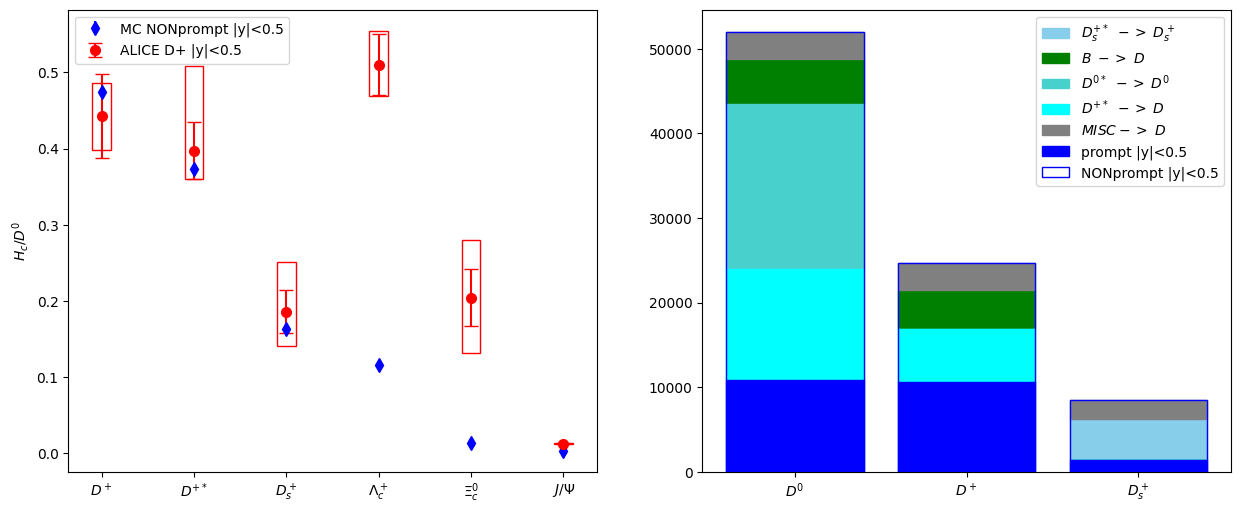

In [ ]:
SIM_health(HERWIG, "D")

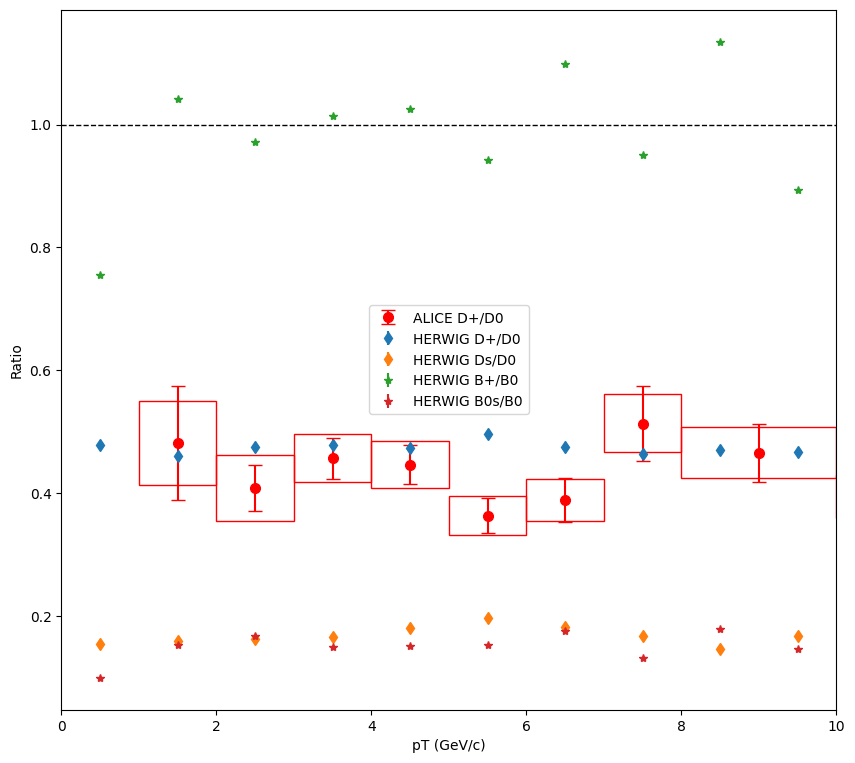

In [ ]:
PlotRatios(["D+/D0","Ds/D0", "B+/B0", "B0s/B0"] , 10, [HERWIG], ["pT"], [[0,10], [0,50]])


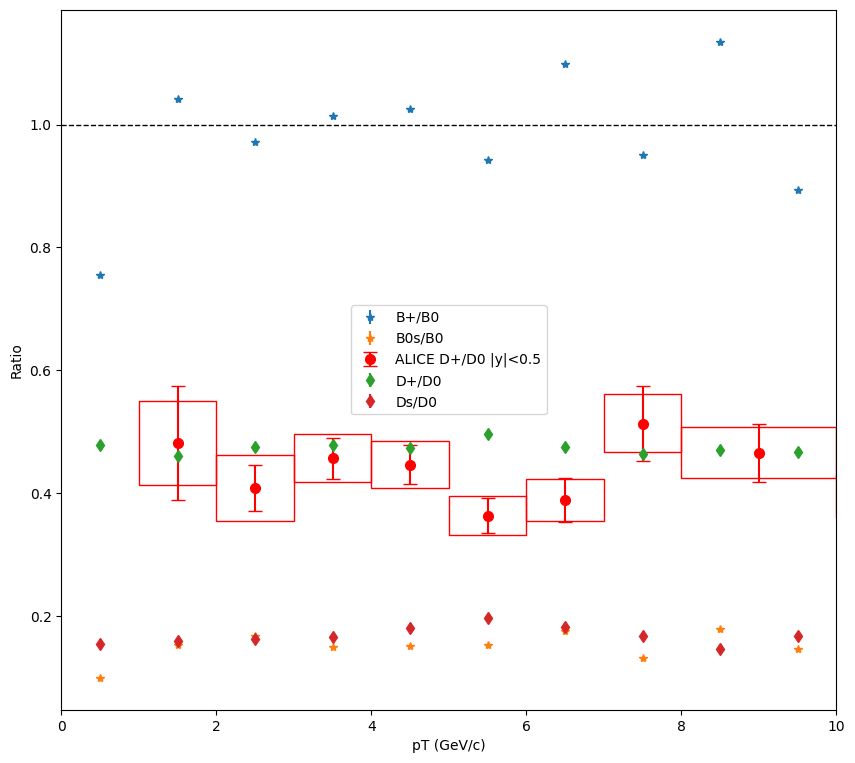

In [ ]:
PlotRatios(["B+/B0","B0s/B0","D+/D0","Ds/D0"] , 10, [HERWIG], ["pT"], [[0,10], [0,50]])


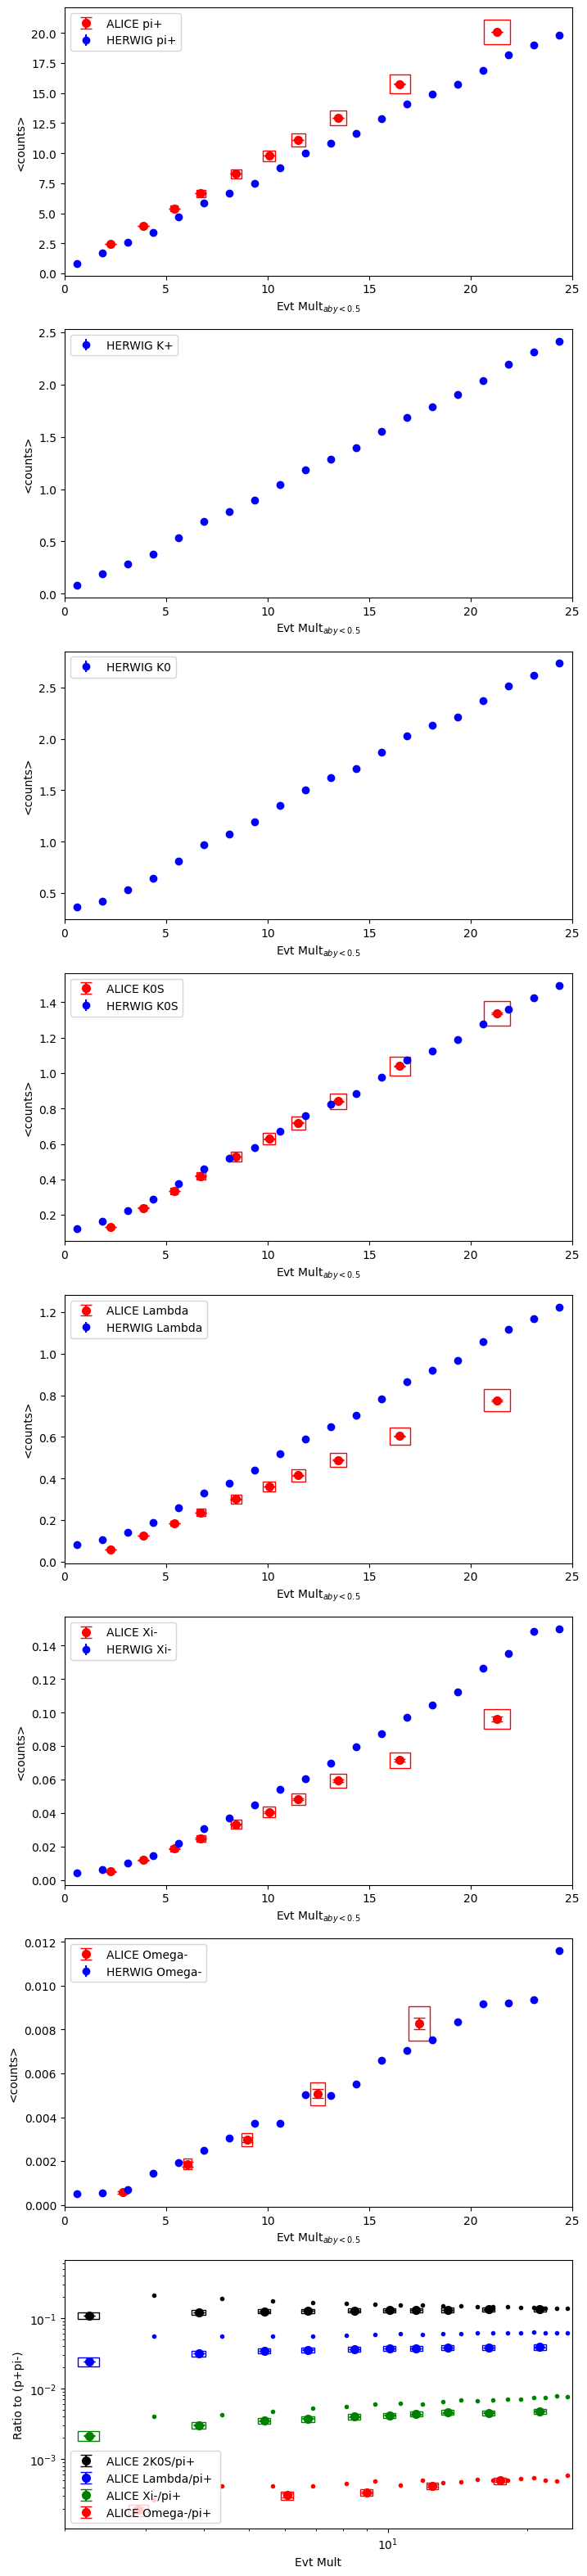

In [ ]:
plotEVTmultH(HERWIG, ["pi+", "K+", "K0", "K0S", "Lambda", "Xi-", "Omega-"], RANGEx=[0,25], BINs=20, racio2pi=1)

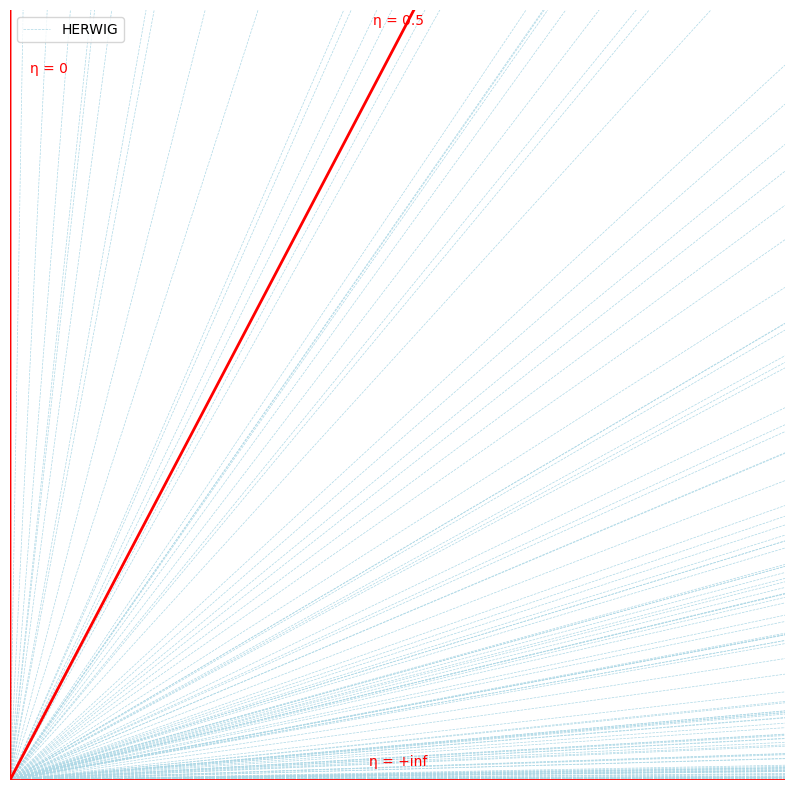

In [ ]:
plot_pseudorapidity_lines([TESTer,HERWIG_T])


Total counts of B0 is: 7876
Total counts of B+ is: 7941
Total counts of B0s is: 1123
Total counts of B0 is: 765
Total counts of B+ is: 711
Total counts of B0s is: 162


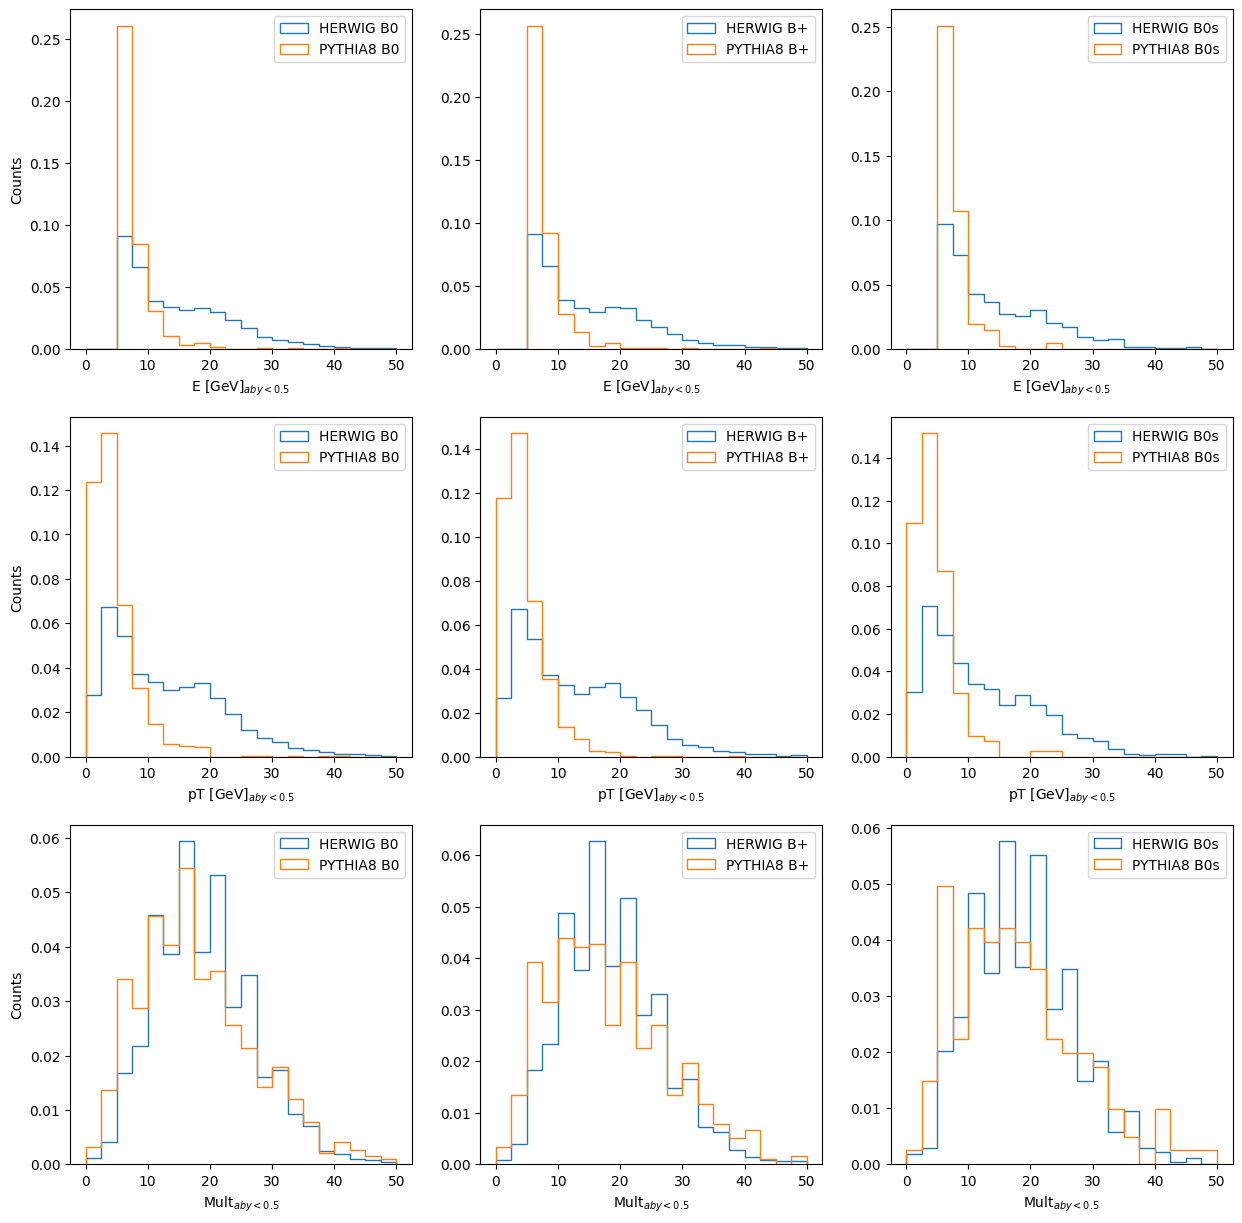

In [ ]:
HERWIG_axs = PLOTdistributions([HERWIG,PYTHIA8], ["B0","B+","B0s"], ["E","pT","Mult"],RANGES=[[0,50],[0,50],[0,50]], NBins=20, norm=1)


Total counts of D0 is: 52028
Total counts of D+ is: 24642
Total counts of Ds is: 8518
Total counts of D0 is: 38021
Total counts of D+ is: 19799
Total counts of Ds is: 6390


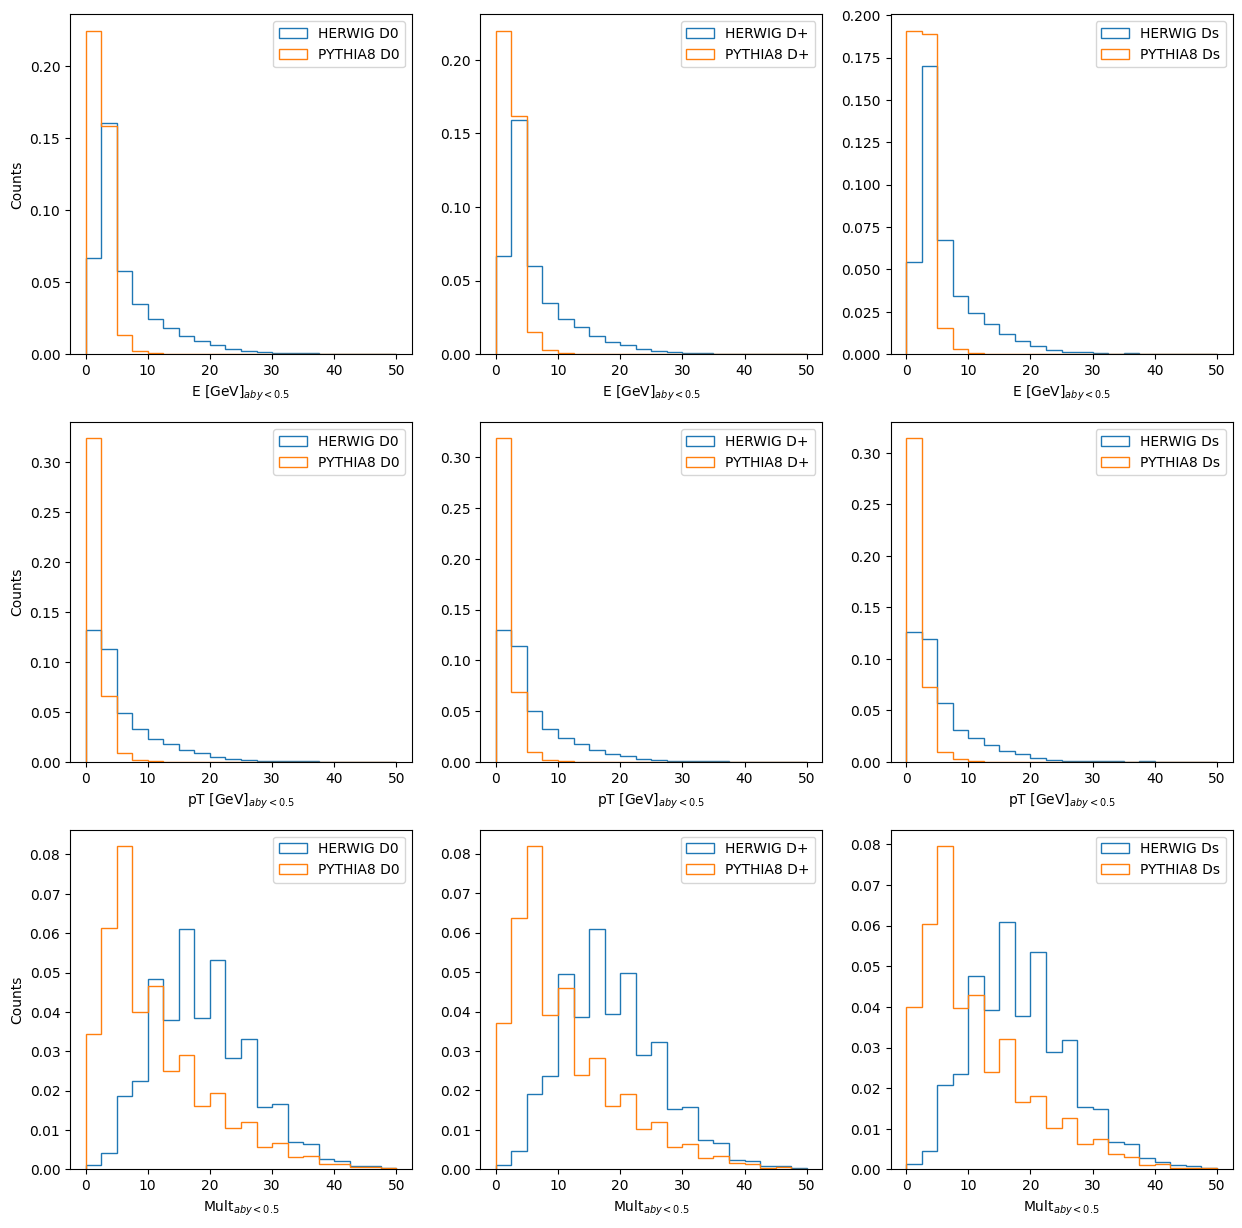

In [ ]:
HERWIG_axs = PLOTdistributions([HERWIG,PYTHIA8], ["D0","D+","Ds"], ["E","pT","Mult"],RANGES=[[0,50],[0,50],[0,50]], NBins=20, norm=1)


Total counts of K0S is: 869112
Total counts of pi+ is: 11400481
Total counts of K0S is: 1750260
Total counts of pi+ is: 27607393


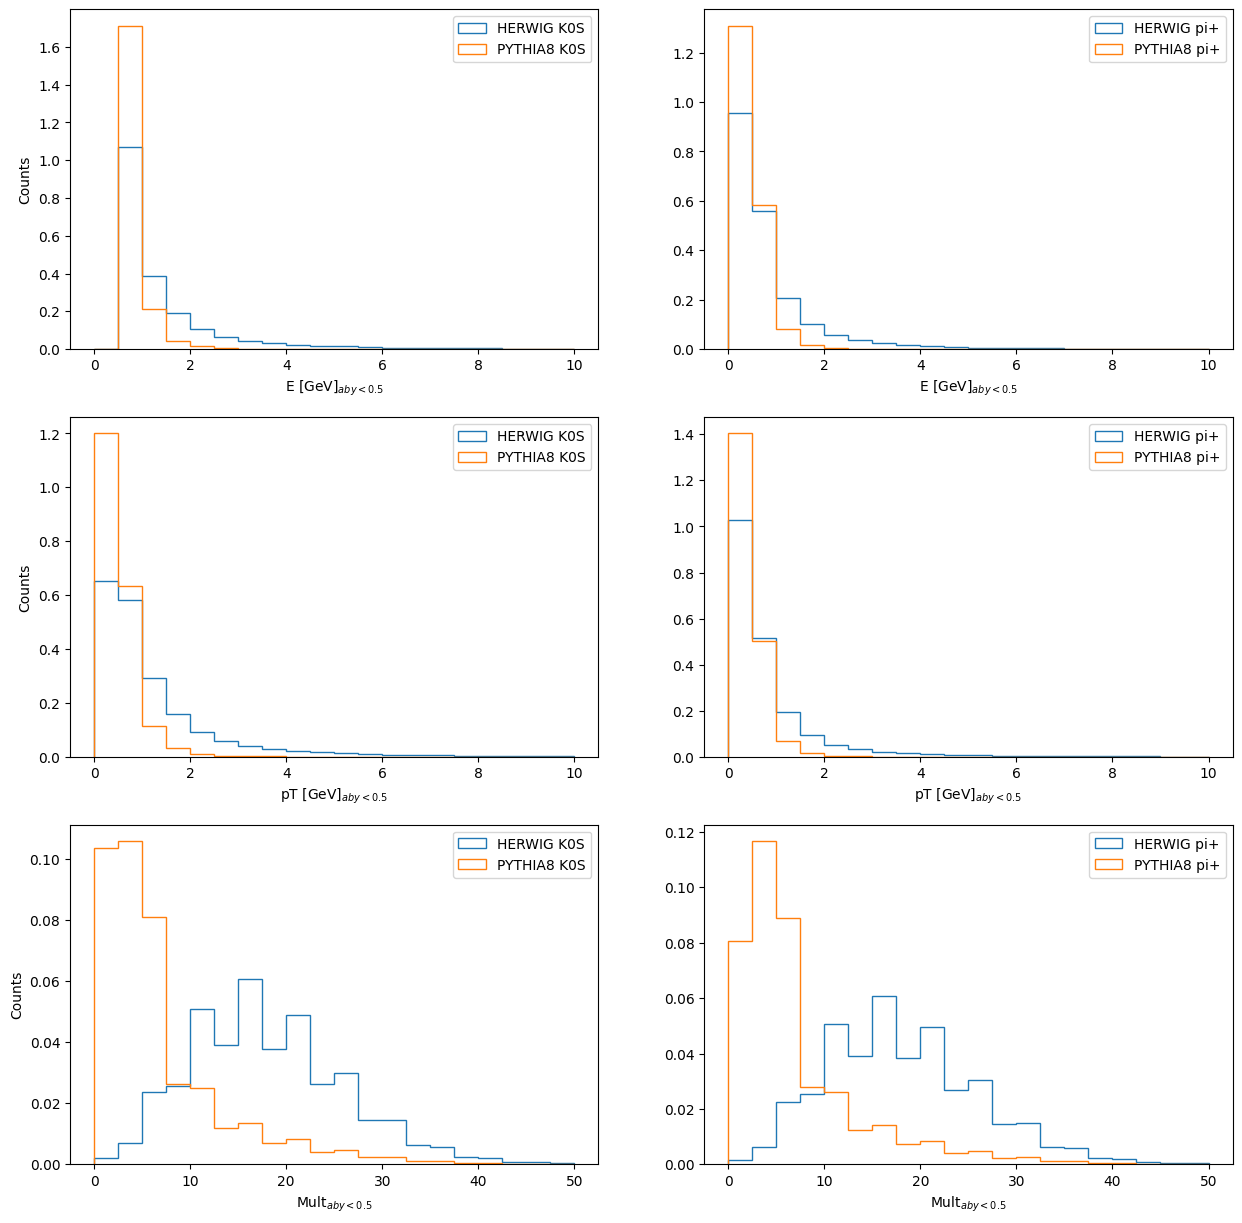

In [ ]:
HERWIG_axs = PLOTdistributions([HERWIG,PYTHIA8], ["K0S","pi+"], ["E","pT","Mult"],RANGES=[[0,10],[0,10],[0,50]], NBins=20, norm=1)
